# __Networks join__ (Boeing+Tessellations networks) Final

This notebook combines the final process of Notebook 08 and Notebook 09.

The code __merges two different street networks into one.__ 
* Boeing is considered network 01, the base network, only the necessary is modified. 
* Tessellations is considered the network 02, the complementary network.
* Only parts of the complementary network that are not in a zone already covered by the base network are added to the base network.

__IMPORTANT: Which one is network 01 and which one is network 02 has an effect on various steps of the process, from deciding what to join to how the final cleaning is performed.__

## Import libraries

In [1]:
accesibilidad_urbana = "../../../"

In [2]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# To create Point from coordinates
from shapely import Point
# For calculate distance between points
import math
# To know if it is a LineString or a MultiLineString, and create them
from shapely.geometry import LineString, MultiLineString
# To split a line using a point in that line
from shapely.ops import split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join(accesibilidad_urbana))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Notebook config

In [3]:
# Projection to be used whenever necessary
projected_crs = "EPSG:32618"

# Save plots in output > figures > volvo > networks_join
save_plots = False
savefig_dir = accesibilidad_urbana+"output/figures/volvo/networks_join/final_process/"

# Boeing input network
boeing_nodes_dir = accesibilidad_urbana+ "data/external/volvo/input_boeing_network/moravia_LH_boeing_nodes.shp"
boeing_edges_dir = accesibilidad_urbana+ "data/external/volvo/input_boeing_network/moravia_LH_boeing_edges.shp"

# Tessellations input network
tess_nodes_dir = accesibilidad_urbana+ "data/external/volvo/output_tessellations_network/moravia_LH_tessellations_nodes_f.gpkg" #From ntbk 06.
tess_edges_dir = accesibilidad_urbana+ "data/external/volvo/output_tessellations_network/moravia_LH_tessellations_edges_f.gpkg" #From ntbk 06.

# Show dirs
print(boeing_nodes_dir)
print(boeing_edges_dir)
print(tess_nodes_dir)
print(tess_edges_dir)

../../../data/external/volvo/input_boeing_network/moravia_LH_boeing_nodes.shp
../../../data/external/volvo/input_boeing_network/moravia_LH_boeing_edges.shp
../../../data/external/volvo/output_tessellations_network/moravia_LH_tessellations_nodes_f.gpkg
../../../data/external/volvo/output_tessellations_network/moravia_LH_tessellations_edges_f.gpkg


## __Part 01 - Step 00__ - Load and preprocess networks

This step __loads input networks__ (Boeing nodes and edges, Tessellations nodes and edges) __and transforms their ID data (nodes 'osmid', edges 'u' and 'v') into coordinates__ using function aup.create_network(). Inside that function a modification was made so that a unique key is assigned to each edge, starting from 0 and increasing by one each time an edge with the same 'u' and 'v' is found.

The resulting networks id data (nodes 'osmid', edges 'u' and 'v') are then modified again to __ensure that there are no duplicates in those columns__, even after concatenating both nodes gdfs and both edges gdfs.

### __Input data__ - Boeing network

In [4]:
# Load nodes data
boeing_nodes = gpd.read_file(boeing_nodes_dir)

# Set CRS
if boeing_nodes.crs != projected_crs:
    try:
        boeing_nodes = boeing_nodes.set_crs(projected_crs)
    except:
        boeing_nodes = boeing_nodes.to_crs(projected_crs)

# Filter and rename data
print(list(boeing_nodes.columns))
boeing_nodes.reset_index(inplace=True)
boeing_nodes = boeing_nodes[['ID','geometry']]
boeing_nodes.rename(columns={'ID':'osmid'},inplace=True)

# Show
print(boeing_nodes.crs)
print(boeing_nodes.shape)
boeing_nodes.head(2)

['ID', 'coord_X', 'coord_Y', 'coord_Z', 'Type', 'geometry']
EPSG:32618
(743, 2)


,osmid,geometry
0,344191636,POINT (437449.345 692995.293)
1,344191639,POINT (437370.198 692566.062)


In [5]:
# Load edges data
boeing_edges = gpd.read_file(boeing_edges_dir)

# Set CRS
if boeing_edges.crs != projected_crs:
    try:
        boeing_edges = boeing_edges.set_crs(projected_crs)
    except:
        boeing_edges = boeing_edges.to_crs(projected_crs)

# Filter and rename data
print(list(boeing_edges.columns))
boeing_edges.reset_index(inplace=True)
boeing_edges['key'] = 0
boeing_edges = boeing_edges[['from','to','key','geometry']]
boeing_edges.rename(columns={'from':'u','to':'v'},inplace=True)

# Show
print(boeing_edges.crs)
print(boeing_edges.shape)
boeing_edges.head(2)

['ID', 'from', 'to', 'length', 'grade_abs', 'speed', 'time', 'Type', 'geometry']
EPSG:32618
(1077, 4)


,u,v,key,geometry
0,344191636,344297704,0,"LINESTRING (437449.345 692995.293, 437415.442 ..."
1,344191636,429632637,0,"LINESTRING (437449.345 692995.293, 437544.786 ..."


In [6]:
# Transform Boeing nodes and edges ID data to coordinates
boeing_coord_nodes, boeing_coord_edges = aup.create_network(boeing_nodes,boeing_edges,projected_crs)
# Set projected crs
boeing_coord_nodes = boeing_coord_nodes.to_crs(projected_crs)
boeing_coord_edges = boeing_coord_edges.to_crs(projected_crs)

Re-registered edge with u 436826692834 and v 436872693033 with key 0.
Re-registered edge with u 436826692834 and v 436872693033 with key 1.
Re-registered edge with u 438049693901 and v 437987693914 with key 0.
Re-registered edge with u 438049693901 and v 437987693914 with key 1.
Re-registered edge with u 436919693239 and v 436939693332 with key 0.
Re-registered edge with u 436919693239 and v 436939693332 with key 1.


In [7]:
duplicated_nodes_ids = len(boeing_coord_nodes.loc[boeing_coord_nodes.duplicated(subset=['osmid'])])

if duplicated_nodes_ids>0:
    print("""Function aup.create_network() created two nodes with the same osmid. 
    This is probably due to two nodes being one meter or less apart from each other.
    These nodes are duplicated, and the edges comming out of each node are now assigned to an osmid with two nodes.
    Development in aup.create_network() is required.
    """)
    intended_crash

# Show
print(boeing_coord_nodes.shape)
print(boeing_coord_nodes.crs)
print(boeing_coord_nodes.dtypes)
print(f"Duplicated osmids on nodes: {duplicated_nodes_ids}.")
boeing_coord_nodes.head(2)

(743, 2)
EPSG:32618
osmid          int64
geometry    geometry
dtype: object
Duplicated osmids on nodes: 0.


,osmid,geometry
0,437449692995,POINT (437449.345 692995.293)
1,437370692566,POINT (437370.198 692566.062)


In [8]:
duplicated_edges_ids = len(boeing_coord_edges.loc[boeing_coord_edges.duplicated(subset=['u','v','key'],keep=False)])

# Show
print(boeing_coord_edges.shape)
print(boeing_coord_edges.crs)
print(boeing_coord_edges.dtypes)
print(f"Duplicated ids on edges: {duplicated_edges_ids}.")
boeing_coord_edges.head(2)

(1077, 5)
EPSG:32618
u              int64
v              int64
key            int64
geometry    geometry
length       float64
dtype: object
Duplicated ids on edges: 0.


,u,v,key,geometry,length
0,437449692995,437415692812,0,"LINESTRING (437449.345 692995.293, 437415.442 ...",185.569367
1,437449692995,437544692963,0,"LINESTRING (437449.345 692995.293, 437544.786 ...",100.577855


### __Input data__ - Tessellations network

In [9]:
# Load nodes data
tess_nodes = gpd.read_file(tess_nodes_dir)

# Set CRS
if tess_nodes.crs != projected_crs:
    try:
        tess_nodes = tess_nodes.set_crs(projected_crs)
    except:
        tess_nodes = tess_nodes.to_crs(projected_crs)

# Filter and rename data
print(list(tess_nodes.columns))
tess_nodes.reset_index(inplace=True)
tess_nodes = tess_nodes[['osmid','geometry']]

# Show
print(tess_nodes.crs)
print(tess_nodes.shape)
tess_nodes.head(2)

['osmid', 'streets_count', 'geometry']
EPSG:32618
(978, 2)


,osmid,geometry
0,0,POINT (437387.239 692067.632)
1,1,POINT (437436.817 692056.015)


In [10]:
# Load edges data
tess_edges = gpd.read_file(tess_edges_dir)

# Set CRS
if tess_edges.crs != projected_crs:
    try:
        tess_edges = tess_edges.set_crs(projected_crs)
    except:
        tess_edges = tess_edges.to_crs(projected_crs)

# Filter and rename data
print(list(tess_edges.columns))
tess_edges.reset_index(inplace=True)
tess_edges = tess_edges[['u','v','key','geometry']]

# Show
print(tess_edges.crs)
print(tess_edges.shape)
tess_edges.head(2)

['u', 'v', 'key', 'geometry']
EPSG:32618
(1601, 4)


,u,v,key,geometry
0,0,1,0,"LINESTRING (437387.239 692067.632, 437387.456 ..."
1,0,3,0,"LINESTRING (437387.239 692067.632, 437387.456 ..."


In [11]:
# Transform Tessellations nodes and edges ID data to coordinates
tess_coord_nodes, tess_coord_edges = aup.create_network(tess_nodes,tess_edges,projected_crs)
# Set projected crs
tess_coord_nodes = tess_coord_nodes.to_crs(projected_crs)
tess_coord_edges = tess_coord_edges.to_crs(projected_crs)

In [12]:
duplicated_nodes_ids = len(tess_coord_nodes.loc[tess_coord_nodes.duplicated(subset=['osmid'],keep=False)])

if duplicated_nodes_ids>0:
    print("""Function aup.create_network() created two nodes with the same osmid. 
    This is probably due to two nodes being one meter or less apart from each other.
    These nodes are duplicated, and the edges comming out of each node are now assigned to an osmid with two nodes.
    Development in aup.create_network() is required.
    """)
    intended_crash

# Show
print(tess_coord_nodes.shape)
print(tess_coord_nodes.crs)
print(tess_coord_nodes.dtypes)
print(f"Duplicated osmids on nodes: {duplicated_nodes_ids}.")
tess_coord_nodes.head(2)

(978, 2)
EPSG:32618
osmid          int64
geometry    geometry
dtype: object
Duplicated osmids on nodes: 0.


,osmid,geometry
0,437387692067,POINT (437387.239 692067.632)
1,437436692056,POINT (437436.817 692056.015)


In [13]:
duplicated_edges_ids = len(boeing_coord_edges.loc[boeing_coord_edges.duplicated(subset=['u','v','key'],keep=False)])

# Show
print(boeing_coord_edges.shape)
print(boeing_coord_edges.crs)
print(boeing_coord_edges.dtypes)
print(f"Duplicated ids on edges: {duplicated_edges_ids}.")
boeing_coord_edges.head(2)

(1077, 5)
EPSG:32618
u              int64
v              int64
key            int64
geometry    geometry
length       float64
dtype: object
Duplicated ids on edges: 0.


,u,v,key,geometry,length
0,437449692995,437415692812,0,"LINESTRING (437449.345 692995.293, 437415.442 ...",185.569367
1,437449692995,437544692963,0,"LINESTRING (437449.345 692995.293, 437544.786 ...",100.577855


### __Input data__ - Network revision

This important step ensures that there are __no repeated osmids and__ that each edge has __unique 'u', 'v' and 'key' data__ on both networks (Not only on each network).

Repeated IDs occur when a node from network 'a' is located at one meter or less of a node from network 'b'.

#### __Show problem__

In [14]:
dup_id = 436813694931

In [15]:
boeing_coord_nodes.loc[boeing_coord_nodes.osmid==dup_id]

,osmid,geometry
223,436813694931,POINT (436813.613 694931.615)


In [16]:
boeing_coord_edges.loc[(boeing_coord_edges.u==dup_id)|(boeing_coord_edges.v==dup_id)]

,u,v,key,geometry,length
475,436813694931,436854694917,0,"LINESTRING (436813.613 694931.615, 436854.924 ...",43.617412


In [17]:
tess_coord_nodes.loc[tess_coord_nodes.osmid==dup_id]

,osmid,geometry
747,436813694931,POINT (436813.982 694931.836)


In [18]:
tess_coord_edges.loc[(tess_coord_edges.u==dup_id)|(tess_coord_edges.v==dup_id)]

,u,v,key,geometry,length
1204,436857694918,436813694931,0,"LINESTRING (436857.223 694918.028, 436857.001 ...",45.498949
1237,436791694861,436813694931,0,"LINESTRING (436791.269 694861.179, 436791.272 ...",74.251937
1238,436813694931,436787694983,0,"LINESTRING (436813.982 694931.836, 436808.907 ...",57.773714


#### __Input data - Network revision -__ Nodes 'osmid' revision

In [19]:
def produce_osmid(nodes_network_1, nodes_network_2, previously_produced):
    
    stop = False
    produced_osmid = previously_produced
    
    while stop == False:

        # Evaluate if fabricated_osmid exists in any network
        if (produced_osmid in list(nodes_network_1.osmid.unique())) or (produced_osmid in list(nodes_network_2.osmid.unique())):
            # Try the next one
            produced_osmid +=1
            
        else:
            # Reached an unique fabricated_osmid
            stop = True
            return produced_osmid

In [20]:
boeing_nodes = boeing_coord_nodes.copy()
boeing_edges = boeing_coord_edges.copy()
tess_nodes = tess_coord_nodes.copy()
tess_edges = tess_coord_edges.copy()

# Make sure all osmids are integers
boeing_nodes['osmid'] = boeing_nodes['osmid'].astype('int')
tess_nodes['osmid'] = tess_nodes['osmid'].astype('int')

# Current existing osmids
boeing_nodes_osmids = list(boeing_nodes.osmid.unique())
tess_nodes_osmids = list(tess_nodes.osmid.unique())

# Find duplicate cases 
dup_osmids = []
for osmid in tess_nodes_osmids:
    if osmid in boeing_nodes_osmids:
        dup_osmids.append(osmid)

if len(dup_osmids) > 0:

    # Used in function produce_osmid():
    previously_produced = 0 # Must be located before starting iterating over osmids

    # For each duplicated node found, modify the tess_nodes and tess_edges:
    # (Could modify either network)
    for current_osmid in dup_osmids:

        # 1.0 --------------- Change the node's osmid
        # Produce a unique osmid (That doesn't exist in either network)
        produced_osmid = produce_osmid(tess_nodes, boeing_nodes, previously_produced)
        # Replace osmid in current tess_node
        osmid_idx = tess_nodes.osmid == current_osmid
        tess_nodes.loc[osmid_idx,'osmid'] = produced_osmid
        print(f"Changed current existing osmid {current_osmid} for osmid {produced_osmid}.")
        # Save already produced osmid to avoid trying the same numbers again and again unnecessarily
        previously_produced = produced_osmid

        # 2.0 --------------- Change the 'u' or 'v' data of the edges that connect to that node
        # Load the edges where that node is used
        u_change_idx = (tess_edges.u==current_osmid)
        tess_edges.loc[u_change_idx,'u'] = produced_osmid
        print(f"Updated 'u' on edges with osmid {produced_osmid}.")

        v_change_idx = (tess_edges.v==current_osmid)
        tess_edges.loc[v_change_idx,'v'] = produced_osmid
        print(f"Updated 'v' on edges with osmid {produced_osmid}.")

else:
    print("Found no duplicate osmid in both nodes gdfs.")

Changed current existing osmid 438140693690 for osmid 0.
Updated 'u' on edges with osmid 0.
Updated 'v' on edges with osmid 0.
Changed current existing osmid 438376693647 for osmid 1.
Updated 'u' on edges with osmid 1.
Updated 'v' on edges with osmid 1.
Changed current existing osmid 437783693648 for osmid 2.
Updated 'u' on edges with osmid 2.
Updated 'v' on edges with osmid 2.
Changed current existing osmid 437688693478 for osmid 3.
Updated 'u' on edges with osmid 3.
Updated 'v' on edges with osmid 3.
Changed current existing osmid 437934693923 for osmid 4.
Updated 'u' on edges with osmid 4.
Updated 'v' on edges with osmid 4.
Changed current existing osmid 437557692532 for osmid 5.
Updated 'u' on edges with osmid 5.
Updated 'v' on edges with osmid 5.
Changed current existing osmid 437544692963 for osmid 6.
Updated 'u' on edges with osmid 6.
Updated 'v' on edges with osmid 6.
Changed current existing osmid 437309693618 for osmid 7.
Updated 'u' on edges with osmid 7.
Updated 'v' on edge

#### __Show problem solved__

In [21]:
boeing_nodes.loc[boeing_nodes.osmid==dup_id]

,osmid,geometry
223,436813694931,POINT (436813.613 694931.615)


In [22]:
boeing_edges.loc[(boeing_edges.u==dup_id)|(boeing_edges.v==dup_id)]

,u,v,key,geometry,length
475,436813694931,436854694917,0,"LINESTRING (436813.613 694931.615, 436854.924 ...",43.617412


In [23]:
tess_nodes.loc[tess_nodes.osmid==dup_id]

,osmid,geometry


In [24]:
tess_edges.loc[(tess_edges.u==dup_id)|(tess_edges.v==dup_id)]

,u,v,key,geometry,length


#### __Input data - Final network revision -__ Joining as they are revision

In [25]:
joined_nodes = pd.concat([boeing_nodes,tess_nodes])
duplicated_nodes_ids = len(tess_coord_nodes.loc[tess_coord_nodes.duplicated(subset=['osmid'],keep=False)])
print(duplicated_nodes_ids)

0


In [26]:
joined_edges = pd.concat([boeing_edges,tess_edges])
duplicated_edges_ids = len(boeing_coord_edges.loc[boeing_coord_edges.duplicated(subset=['u','v','key'],keep=False)])
print(duplicated_edges_ids)

0


### __Input data__ - Preprocessed input visualization

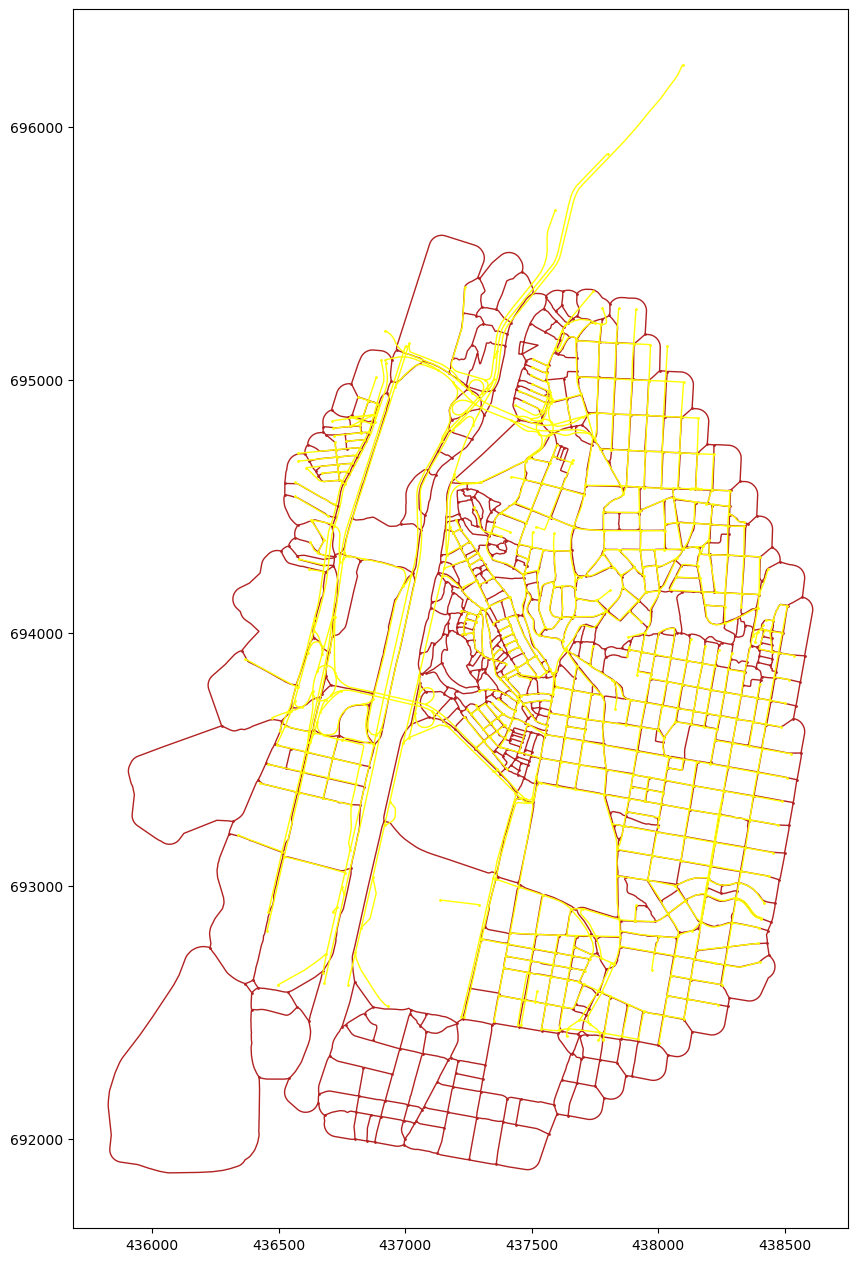

In [27]:
# Plot
fig,ax = plt.subplots(1,1,figsize=(10,20))

boeing_nodes.plot(ax=ax,zorder=3,color='yellow',markersize=1)
boeing_edges.plot(ax=ax,zorder=2,color='yellow',linewidth=1)
tess_nodes.plot(ax=ax,zorder=1,color='firebrick',markersize=1)
tess_edges.plot(ax=ax,zorder=0,color='firebrick',linewidth=1)

# ---------- Save Plot ----------
if save_plots:
    plt.savefig(savefig_dir + "part01_step01_preprocess.svg")

In [28]:
local_save = False
output_dir = accesibilidad_urbana + f"data/external/volvo/output_networks_join/final_process/part01_step01_preprocess/"
if local_save:
    boeing_nodes.to_file(output_dir + "boeing_nodes.gpkg")
    boeing_edges.to_file(output_dir + "boeing_edges.gpkg")
    tess_nodes.to_file(output_dir + "tess_nodes.gpkg")
    tess_edges.to_file(output_dir + "tess_edges.gpkg")

## __Part 01 - Step 01__ - Identify the parts of the Tessellations network that should be added to the Boeing network

This step identifies identifies the parts of the Tessellations network that should be added to the boeing network through the following steps:

base_network: boeing
complementary_network: tessellations

1. Extract the midpoint of each complementary edge
2. Create a contact-analysis buffer around mid_points
3. Find mid_points whose buffer does not intersect with any part of the base network
4. Select the complementary_nodes that connect to the uncovered edges found
5. Find the nodes that would be used to connect the uncovered part of the complementary network to the base network
6. Identify and shorten edges that extend into the base network and would be useful to create further connections

### __Part 01 - Step 01 -__ Functions required 

In [29]:
# Distance between two points
def distance_between_points(point1, point2):
    return round(math.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2), 2)

In [30]:
def edge_clipping(starting_point_gdf, edge_gdf, clipping_point_gdf, projected_crs="EPSG:6372", return_all=False, function_logs=False):
    
    """ This function clips an edge by considering a starting point and a clipping point.
    
	Args:
		starting_point_gdf (geopandas.GeoDataFrame): GeoDataFrame containing the starting point of the LineString, helps identify each split part. 
                                                     Requires column 'geometry' with a Point.
        edge_gdf (geopandas.GeoDataFrame): GeoDataFrame containing the edge to be clipped. 
                                           Requires column 'geometry' with a LineString.
        clipping_point_gdf (geopandas.GeoDataFrame): GeoDataFrame containing the clipping point of the LineString.
                                                     Requires column 'geometry' with a Point.
        projected_crs (str, optional): string containing projected crs to be used depending on area of interest. Defaults to "EPSG:6372".
        return_all (bool,optional): Boolean that defines whether the clipped edge is returned from starting_point to clipping_point only (One line) (False)
                                    or returned from starting_point to clipping_point and then from clipping_point to ending_point (Two lines) (True). 
                                    Defaults to False.
        function_logs (bool,optional): Boolean that (if True) prints logs during the functions execution. Defaults to False.
                                                 
	Returns:
        split_edge_gdf (geopandas.GeoDataFrame): GeoDataFrame with either one (return_all=False) or two (return_all=True) edges.
	"""
    
    # 1.0 --------------- Split the edge using the clipping_point. Creates two separate edges.
    # Extract the edge's geometry (LineString)
    edge_geom = edge_gdf['geometry'].unique()[0]
    # Extract the clipping_point's geometry (Point)
    clipping_point_geom = clipping_point_gdf['geometry'][0]
    # Project the clipping_point onto the edge (In case it's not drawn exactly in the LineString)
    projected_point = edge_geom.interpolate(edge_geom.project(clipping_point_geom))
    
    # ----- ----- Added code since having trouble clipping with a point ----- -----
    # Create a VERY SMALL buffer around the projected_point
    projected_point = projected_point.buffer(1e-9)
    # ----- ----- Added code since having trouble clipping with a point ----- -----
    
    # Split the edge where the projected clipping_point is
    split_lines = split(edge_geom, projected_point)
    # Convert the split lines to a GeoDataFrame
    split_gdf = gpd.GeoDataFrame(geometry=list(split_lines.geoms), crs=projected_crs)
    
    # ----- ----- Added code since having trouble clipping with a point ----- -----
    # Drop the small split line located inside the VERY SMALL buffer in order to keep the two split lines outside it.
    if len(split_gdf) ==3 :
        split_gdf['length'] = split_gdf.length
        split_gdf = split_gdf.loc[split_gdf.length != split_gdf.length.min()]
    split_gdf.reset_index(inplace=True,drop=True)
    # ----- ----- Added code since having trouble clipping with a point ----- -----

    # 2.0 --------------- Find which split LineString in split_gdf contains the LineString where the starting_point is located
    
    # Extract the edge's first and last coordinates
    edge_coords = list(edge_gdf['geometry'][0].coords)
    first_point_coords = edge_coords[0]
    last_point_coords = edge_coords[-1]

    if function_logs:
        print(f"edge_clipping(): Extracted first_point_coords: {first_point_coords}.")
        print(f"edge_clipping(): Extracted last_point_coords: {last_point_coords}.")
    
    # Extract the starting_point's coordinates (Function input)
    starting_point_coords = starting_point_gdf.loc[0,'geometry'].coords[0]
    if function_logs:
        print(f"edge_clipping(): Extracted starting_point_coords: {starting_point_coords}.")
        
    # Try identifying which (first or last) is the starting_point by checking equality in coordinates
    if starting_point_coords == first_point_coords:
        # Starting point is first_point
        starting_point_coords = first_point_coords
    elif starting_point_coords == last_point_coords:
        # Starting point is last_point
        starting_point_coords = last_point_coords
    # Else, measure distance and assume the starting_point is the closest one.
    # (this case applies when starting_point is not drawn exactly in the LineString)
    else:
        # Distance from starting_point to first point
        first_point_distance = distance_between_points(first_point_coords, starting_point_coords)
        # Distance from starting_point to last point
        last_point_distance = distance_between_points(last_point_coords, starting_point_coords)
        # Find which one is the starting_point
        if first_point_distance < last_point_distance:
            # Starting point is first_point
            starting_point_coords = first_point_coords
        else:
            # Starting point is last_point
            starting_point_coords = last_point_coords
    
    # 3.0 --------------- Select split LineString where the starting_point is.
    
    # Find which line from split_gdf has the starting_point_coords
    # Extract both lines (starting and ending line)
    if starting_point_coords in list(split_gdf.loc[0,'geometry'].coords):
        split_edge_geom_start = split_gdf.loc[0,'geometry'] # Extract first line geometry
        split_edge_geom_end = split_gdf.loc[1,'geometry'] # Second line geometry
        
    elif starting_point_coords in list(split_gdf.loc[1,'geometry'].coords):
        split_edge_geom_start = split_gdf.loc[1,'geometry'] # Extract second line geometry
        split_edge_geom_end = split_gdf.loc[0,'geometry'] # Second line geometry
        
    # Convert to a GeoDataFrame
    split_edge_gdf = gpd.GeoDataFrame()
    split_edge_gdf.loc[0,'geometry'] = split_edge_geom_start
    
    # 4.0 --------------- (Optional) Include split other LineString.
    if return_all:
        split_edge_gdf.loc[1,'geometry'] = split_edge_geom_end
        split_edge_gdf.loc[0,'relation'] = 'starting'
        split_edge_gdf.loc[1,'relation'] = 'ending'

    # Final format
    split_edge_gdf = split_edge_gdf.set_crs(projected_crs)

    return split_edge_gdf

In [31]:
def create_unique_edge_id(edges_gdf):
    # Turn ID data to string
    edges_gdf['u'] = edges_gdf['u'].astype('str')
    edges_gdf['v'] = edges_gdf['v'].astype('str')
    edges_gdf['key'] = edges_gdf['key'].astype('str')
    # Concatenate ID data to create unique edge_id
    edges_gdf['edge_id'] = edges_gdf['u']+edges_gdf['v']+edges_gdf['key']
    # Turn ID data back to int
    edges_gdf['u'] = edges_gdf['u'].astype('int')
    edges_gdf['v'] = edges_gdf['v'].astype('int')
    edges_gdf['key'] = edges_gdf['key'].astype('int')

    return edges_gdf

In [32]:
def identify_uncovered(base_nodes, base_edges, complementary_nodes, complementary_edges, contact_analysis_dist, projected_crs="EPSG:6372"):
    """ This function identifies zones within a complementary network (nodes and edges) where currently there's no coverture in a base network.
	Args:
		base_nodes (geopandas.GeoDataFrame): GeoDataFrame containing nodes of the base network. 
        base_edges (geopandas.GeoDataFrame): GeoDataFrame containing edges of the base network. 
		complementary_nodes  (geopandas.GeoDataFrame): GeoDataFrame containing nodes of the complementary network.
		complementary_edges  (geopandas.GeoDataFrame): GeoDataFrame containing edges of the complementary network.
		contact_analysis_dist (float): Distance (meters) used when deciding which nodes from the complementary network should be added to the base network.
                                A buffer of {contact_analysis_dist} is created around all center points of each complementary_edge.
                                If the buffer touches any base_edges, the complementary_edge is considered as already covered by the base network. 
                                If the buffer does not touches any base_edge, the complementary_edge is considered uncovered.
		projected_crs (str, optional): string containing projected crs to be used depending on area of interest. Defaults to "EPSG:6372".

	Returns:
        complementary_uncovered_nodes (geopandas.GeoDataFrame): GeoDataFrame with nodes from the complementary network that are located 
                                                                in a zone not covered by the base network.
        complementary_uncovered_nodes (geopandas.GeoDataFrame): GeoDataFrame with edges from the complementary network that are located
                                                                in a zone not covered by the base network.
		contact_nodes (geopandas.GeoDataFrame): GeoDataFrame with nodes from the complementary network that could be used to 
                                                connect an uncovered zone to a covered zone.
	"""

    # Turn on or off function logs
    function_logs = True
    
    # 1.0 --------------- Extract mid_point of each complementary edge
    if function_logs:
        print("1.0 - Extracting mid_point point of each complementary edge.")
    # ------------------- INPUT USED - READ COMPLEMENTARY EDGES
    complementary_edges = complementary_edges.copy()
    complementary_edges = complementary_edges.to_crs(projected_crs)
    # ------------------- INPUT USED - READ COMPLEMENTARY EDGES

    # Create unique ID for each edge using u+v+key
    complementary_edges = create_unique_edge_id(complementary_edges)
    # Find mid_point of each edge
    complementary_edges['mid_point'] = complementary_edges.interpolate(complementary_edges.length / 2)
    # Assign mid_point to its own gdf and drop mid_point from complementary_edges
    mid_points = complementary_edges[['edge_id','mid_point']].copy()
    mid_points.rename(columns={'mid_point':'geometry'},inplace=True)
    complementary_edges.drop(columns=['mid_point'],inplace=True)
    
    # 2.0 --------------- Create contact-analysis buffer around mid_points using contact_analysis_dist 
    # ------------------- (keep edge of origin data)
    if function_logs:
        print("2.0 - Creating contact-analysis buffer around each mid_point.")
    
    # Reset mid_points's index (Keeps data ordered starting from 0)
    mid_points.reset_index(inplace=True,drop=True) #--> Resets index without saving col 'index'
    # Save each mid_point's reseted index in a column named 'index'
    points_to_buffer = mid_points.copy()
    points_to_buffer.reset_index(inplace=True) #--> Also creates a col 'index', same order since it is reseted
    # Create a gdf containing the contact-analysis buffer around mid_points
    mid_points_buffer = points_to_buffer.buffer(contact_analysis_dist)
    mid_points_buffer = gpd.GeoDataFrame(geometry=mid_points_buffer)
    mid_points_buffer.reset_index(inplace=True) #--> Also creates a col 'index', same order since it is reseted
    # Transfer data from mid_points to it's buffer using the previously reseted index as merge col
    points_to_buffer.drop(columns=['geometry'],inplace=True)
    mid_points_buffer = pd.merge(mid_points_buffer,points_to_buffer,on='index') #--> Merges using common reseted col 'index'
    mid_points_buffer.drop(columns=['index'],inplace=True)

    # Save disk space
    del points_to_buffer
    
    # 3.0 --------------- Find mid_points whose buffer does not intersect with any part of the base network (Considering base_edges).
    # ------------------- [This step creates COMPLEMENTARY_UNCOVERED_EDGES]
    if function_logs:
        print("3.0 - Extracting complementary_uncovered_edges.")
    
    # ------------------- INPUT USED - READ BASE EDGES
    base_edges = base_edges.copy()
    base_edges = base_edges.to_crs(projected_crs)
    # ------------------- INPUT USED - READ BASE EDGES
    
    # Buffers that touch any base edge
    buffer_touch = mid_points_buffer.sjoin(base_edges)
    # All unique complementary edge_ids that touched any base_edge
    edge_id_touch_lst = list(buffer_touch.edge_id.unique())
    # Complementary edges that are NOT(~) near any base edge
    complementary_uncovered_edges = complementary_edges.loc[~complementary_edges.edge_id.isin(edge_id_touch_lst)].copy()
    complementary_uncovered_edges.reset_index(inplace=True,drop=True) #--> Resets index without saving col 'index'

    # 4.0 --------------- Select the complementary_nodes that connect to the complementary_uncovered_edges
    # ------------------- [This step creates COMPLEMENTARY_UNCOVERED_NODES]
    if function_logs:
        print("4.0 - Extracting complementary_uncovered_nodes.")
    
    # ------------------- INPUT USED - READ COMPLEMENTARY NODES
    complementary_nodes = complementary_nodes.copy()
    complementary_nodes = complementary_nodes.to_crs(projected_crs)
    # ------------------- INPUT USED - READ COMPLEMENTARY NODES 
    
    # List of unique 'u's and 'v's that are connected to the complementary_uncovered_edges 
    complementary_uncovered_osmid_lst = set(list(complementary_uncovered_edges.u.unique()) + list(complementary_uncovered_edges.v.unique()))
    # Select any node where its 'osmid' IS in complementary_uncovered_osmid_lst
    complementary_uncovered_nodes = complementary_nodes.loc[complementary_nodes.osmid.isin(complementary_uncovered_osmid_lst)].copy()
    # [Note: This nodes won't necessarily be in the uncovered zone since they could belong to 
    # an edge whose mid_point is far from the base network, but whose path extends into the base network.]

    # 5.0 --------------- Find the nodes that would be used to connect the uncovered part of the complementary network to the base network.
    # ------------------- [This step creates CONTACT_NODES]
    if function_logs:
        print("5.0 - Extracting contact_nodes.")

    # 5.1 --- Create a buffer around all complementary_uncovered_nodes 
    # Reset complementary_uncovered_nodes's index
    complementary_uncovered_nodes.reset_index(inplace=True,drop=True) #--> Resets index without saving col 'index'
    # Save each complementary_uncovered_nodes's reseted index in a column named 'index'
    nodes_to_buffer = complementary_uncovered_nodes.copy()
    nodes_to_buffer.reset_index(inplace=True) #--> Also creates a col 'index', same order since it is reseted
    # Create a gdf containing the buffer around complementary_uncovered_nodes
    complementary_uncovered_nodes_buffer = nodes_to_buffer.buffer(contact_analysis_dist)
    complementary_uncovered_nodes_buffer = gpd.GeoDataFrame(geometry=complementary_uncovered_nodes_buffer)
    complementary_uncovered_nodes_buffer.reset_index(inplace=True) #--> Also creates a col 'index', same order since it is reseted
    # Transfer data from complementary_uncovered_nodes to it's buffer using the index as merge col
    nodes_to_buffer.drop(columns=['geometry'],inplace=True)
    complementary_uncovered_nodes_buffer = pd.merge(complementary_uncovered_nodes_buffer,nodes_to_buffer,on='index') #--> Merges using common reseted col 'index'
    complementary_uncovered_nodes_buffer.drop(columns=['index'],inplace=True)

    # Save disk space
    del nodes_to_buffer
    
    # 5.2 --- Find complementary_uncovered_nodes whose buffer DOES intersect with any part of the base network (Considering base_edges).
    # Buffers that touch any base edge
    buffer_touch = complementary_uncovered_nodes_buffer.sjoin(base_edges)
    # All unique osmids that touched any base_edge
    contact_osmids = list(buffer_touch.osmid.unique())
    # Complementary nodes that ARE near any base_edge
    contact_nodes = complementary_uncovered_nodes.loc[complementary_uncovered_nodes.osmid.isin(contact_osmids)].copy()
    contact_nodes.reset_index(inplace=True,drop=True) #--> Resets index without saving col 'index'

    # 6.0 --------------- Identify and shorten edges that extend into the base network and would be usefull to create connections.
    # ------------------- (Currently those edges are not being considered since they extend to the base network, its
    # ------------------- mid_points_buffer is in contact with the base network. This step takes the edge and shortens (Clips)
    # ------------------- the edge until it's mid_point_buffer is no longer in contact with the base network)
    # ------------------- [This step updates the uncovered network and the contact nodes]
    if function_logs:
        print("6.0 - Creating missing connections through complementary_edges that travel from the uncovered zone to the base network.")

    # PREPARATION FOR ANALYSIS:

    # Keep track of the amount of edges that underwent a shortening process
    fabricated_count = 0

    # LOG CODE - Progress logs
    # Will create progress logs when progress reaches these percentages:
    progress_logs = [10,20,30,40,50,60,70,80,90,100] # for log statistics
    osmid_count = 0
    # LOG CODE - Progress logs

    # Create empty GeoDataFrame to store all original_diverging_nodes and original_diverging_edges (For GIS Visualization purposes)
    original_diverging_nodes = gpd.GeoDataFrame()
    original_diverging_edges = gpd.GeoDataFrame()
    
    # Find all complementary_uncovered_osmids (from previously created complementary_uncovered_osmid_lst)
    # that are NOT a contact osmid (Those that already serve as a connection to the base network)
    non_contact_osmids = [osmid for osmid in complementary_uncovered_osmid_lst if osmid not in contact_osmids]
    
    # Previously produced osmid. Since will be creating non-existing nodes, function produce_osmid() will use a starting number for
    # trying to produce unique osmids. That function will check if that osmid already exists in either the base or complementary network.
    # Start with number 0.
    previously_produced = 0

    # Read base_nodes once (will be used to assess if the osmid being produced is unique)
    # ------------------- INPUT USED - READ BASE EDGES
    base_nodes = base_nodes.copy()
    base_nodes = base_nodes.to_crs(projected_crs)
    # ------------------- INPUT USED - READ BASE EDGES

    # Keep track of which parts of the network where fabricated with the following code.
    # All edges that keep its original geometry will be assigned 'clipping_i' = 0.
    # All edges whose geometry was clipped will be assigned the amount of shortening (clipping) iterations used in them.
    complementary_uncovered_nodes['clipping_i'] = 0
    complementary_uncovered_edges['clipping_i'] = 0
    complementary_uncovered_edges['original_edge_id'] = np.nan
    contact_nodes['clipping_i'] = 0

    # Shortening dict
    # Sometimes an edge could get shortened from both sides. 
    # (Clipped with starting point 'u' and then, on another case, clipped with starting point 'u')
    # If an edge will be shortened from both sides, make sure that if the edge is shortened just once in both sides 
    # (Shortened from 'u' to midpoint and from 'v' to midpoint), only one contact_node is created.
    # If not considered, this particular situation can create two different edges that coincide in two different contact_nodes exactly in the midpoint.
    # This is the main reason why it is necessary to keep track of which edges where shortened and up to which point.
    shortening_dict = {}
    
    # Review each node in the uncovered zone of the complementary network (Previously created complementary_uncovered_osmid_lst)
    for osmid in non_contact_osmids:

        # Development check
        #if osmid != 436813694931:
        #    continue
        #else:
        #    print(osmid)
        
        # LOG CODE - Progress logs
        # Measures current progress, prints if passed a checkpoint of progress_logs list.
        current_progress = (osmid_count / len(non_contact_osmids))*100
        for checkpoint in progress_logs:
            if (current_progress >= checkpoint) and function_logs:
                print(f'Exploring osmids. {checkpoint}% done.')
                progress_logs.remove(checkpoint)
                break
        # LOG CODE - Progress logs

        # Retrieve it's edges (Will be refered as diverging_edges). 
        # Must consider all edges (complementary_edges) and not only complementary_uncovered_edges since
        # since it's looking to identify if an edge that comes out of that osmid goes towards base_network.
        diverging_edges = complementary_edges.loc[(complementary_edges.u==osmid) | (complementary_edges.v==osmid)].copy()
        diverging_edges_ids = list(diverging_edges.edge_id.unique())
        
        # For each edge diverging from current node:
        for diverging_edge_id in diverging_edges_ids:
            # If the edge DOES touch the base network:
            if diverging_edge_id in edge_id_touch_lst: # (Previously created edge_id_touch_lst)
                # If an edge reaches this part of the code, it means that it is a complementary_edge that:
                # a) Comes out from an node that's located in the uncovered zone (complementary_uncovered_node).
                # b) The node it came out from is NOT a contact_node, it is far from the base network (According to contact_analysis_dist)
                # c) The edge's current mid_point is located in proximity to the base network (According to contact_analysis_dist)
                # --> Between the base_network and this edge itself, a connection point should be identified.
                # --> Objective: Identify that connection (new contact_node) between the complementary and base network.

                # 6.1 --- Retrieve current diverging_osmid and diverging_node
                # Save the osmid from the node which the current edge uses to come out from the uncovered zone into the base network.
                diverging_osmid = osmid
                # Extract its node
                diverging_node = complementary_uncovered_nodes.loc[complementary_uncovered_nodes.osmid == diverging_osmid].copy()
                # Reset index (so that accessing its geometry is always .loc[0,'geometry'])
                diverging_node.reset_index(inplace=True, drop=True)
                # Add current diverging_node to original_diverging_nodes gdf (For GIS visualization purposes)
                original_diverging_nodes = pd.concat([original_diverging_nodes, diverging_node])

                # 6.2 --- Retrieve current diverging_edge as the connection_edge
                # Select the edge that diverts from the diverging_node towards the base_network
                connection_edge = complementary_edges.loc[complementary_edges.edge_id == diverging_edge_id].copy()
                # Reset index (so that accessing its data is always .loc[0,'data'])
                connection_edge.reset_index(inplace=True,drop=True)
                # The connection_edge geometry will suffer modifications, save original
                original_connection_edge = connection_edge.copy() 
                # Add current connection_edge to original_diverging_edges gdf (For GIS visualization purposes)
                original_diverging_edges = pd.concat([original_diverging_edges, connection_edge])

                # 6.3 --- Clip connection_edge until it's mid_point is no longer in proximity to the base network.
                # ------- When this point is reached, assign its ending_point (previous mid_point) as a new contact_node.
            
                # Kickstart while loop for current connection_edge
                stop = False
                shorten_i = 0
                
                while (stop == False):

                    # Limit of attempts
                    limit_of_attempts = 20
                    if shorten_i >= limit_of_attempts:
                        print(f"Tried shortening {limit_of_attempts} times edge u {original_connection_edge.u.unique()[0]} and v {original_connection_edge.v.unique()[0]}. Stopped.")
                        break
                        
                    # 6.3.1 --- Calculate the edge's mid_point.
                    # --------- [Will become the clipping_point in function edge_clipping()].
                
                    # Calculate the connection_edge's mid_point
                    connection_edge['mid_point'] = connection_edge.interpolate(connection_edge.length / 2)
                    # Assign mid_point to its own gdf and drop mid_point from connection_edge gdf
                    edge_mid_point = connection_edge[['edge_id','mid_point']].copy()
                    edge_mid_point.rename(columns={'mid_point':'geometry'},inplace=True)
                    connection_edge.drop(columns=['mid_point'],inplace=True)
                
                    # 6.3.2 --- Evaluate if the current mid_point is still in proximity to the base network
                    # 6.3.2.a - Create contact-analysis buffer around the edge_mid_point
                    # Reset edge_mid_point's index
                    edge_mid_point.reset_index(inplace=True,drop=True) #--> Resets index without saving col 'index'
                    # Save edge_mid_point's reseted index in a column named 'index'
                    point_to_buffer = edge_mid_point.copy()
                    point_to_buffer.reset_index(inplace=True) #--> Also creates a col 'index', same order since it is reseted
                    # Create a gdf containing the contact-analysis buffer around the edge_mid_point
                    mid_point_buffer = point_to_buffer.buffer(contact_analysis_dist)
                    mid_point_buffer = gpd.GeoDataFrame(geometry=mid_point_buffer)
                    mid_point_buffer.reset_index(inplace=True) #--> Also creates a col 'index', same order since it is reseted
                    # Transfer data from edge_mid_point to it's buffer using the previously reseted index as merge col
                    point_to_buffer.drop(columns=['geometry'],inplace=True)
                    mid_point_buffer = pd.merge(mid_point_buffer,point_to_buffer,on='index') #--> Merges using common reseted col 'index'
                    mid_point_buffer.drop(columns=['index'],inplace=True)
                    
                    # 6.3.2.b - Find if current mid_point it's still in proximity to base network
                    # Buffers that touch any base edge
                    buffer_touch = mid_point_buffer.sjoin(base_edges)
                    
                    if len(buffer_touch) > 0:
                        
                        # 6.3.3 --- If it still touches, reduce in size.
                        # If the mid_point_buffer still touches the base edges, the line is most likely still overlaping with the base network.
                        # Apply edge_clipping function to shorten the edge up until the current mid_point
                        connection_edge = edge_clipping(starting_point_gdf = diverging_node,
                                                        edge_gdf = connection_edge,
                                                        clipping_point_gdf = edge_mid_point,
                                                        projected_crs = projected_crs)
                        # Keep connection_edge format
                        connection_edge['edge_id'] = diverging_edge_id
                        # Count shortening iteration
                        shorten_i+=1
                    
                    else:
                        # 6.3.3 --- If the buffer no longer touches any part of the base network, shortening was a success.
                        # --------- However, before registering the shortened edge it it necessary to run a test:
                        
                        # Double-once-shortening test STARTS ### ### ### ### ### ### ### ### ### ### ### ### 
                        # EXPLANATION:
                        # A complementary_edge could be shortened twice, once from each starting_point. This is a "double shortening".
                        # It occurs when an edge was shortened from node 1 (e.g. from 'u') and now is being shortened from node 2 (e.g. from 'v').
                        # This process produces no problems, **unless both shortening processess undergo just 1 iteration**.
                        # In that specific case, both lines start in their nodes ('u' or 'v') and end at the original line's midpoint.
                        # This produces TWO different contact_nodes in a very similar location, that could result in TWO similar but different treatments and strange geometries.
                        # In order to avoid this, this double_shortening check is conduced in order to make sure that 
                        # at the end of both processes, just ONE contact node is produced and used by both edges ending on it.

                        # If this is NOT the first fabrication case and edge AND the current edge was shortened ONLY once:
                        if (fabricated_count > 0) and (shorten_i==1):
    
                            # Load all original edge_ids that have been shortened ONLY once
                            already_shortened_once = complementary_uncovered_edges.loc[complementary_uncovered_edges.clipping_i==1].copy()
                            already_shortened_once_lst = list(already_shortened_once.original_edge_id.unique())

                            # Check if current diverging_edge_id has already been shortened ONLY once
                            if diverging_edge_id in already_shortened_once_lst:
                                # If an edge reaches this part of the code, the edge was already shortened ONCE from one end, and was being shortened again ONCE from the other end.
                                # Next step --> Do NOT produce a new contact osmid and new point for current edge. Use the existing one. 
                                # ------------> Register the edge under the existing contact_node instead of creating a new one.

                                # 6.3.3.a1 - Identify the previously produced middle osmid.
                                # Retrieve the ORIGINAL (current original_connection_edge's) 'u' and 'v'
                                original_u = original_connection_edge.u.unique()[0]
                                original_v = original_connection_edge.v.unique()[0]
                                original_osmids = [original_u, original_v]
                                print(original_osmids)
                                # Retrieve the PREVIOUSLY PRODUCED (previously shortened edge) 'u' and 'v'
                                prev_produced_edge = complementary_uncovered_edges.loc[complementary_uncovered_edges.original_edge_id == diverging_edge_id].copy()
                                new_u = prev_produced_edge.u.unique()[0]
                                new_v = prev_produced_edge.v.unique()[0]
                                new_osmids = [new_u, new_v]
                                print(new_osmids)
                                # Identify which osmid is in the new _osmids but not in the original_osmids 
                                # (Which osmid was produced here, in step 6.3.3)
                                for osmid in new_osmids:
                                    if osmid not in original_osmids:
                                        produced_osmid = osmid

                                # 6.3.3.a2 - Add the connection_edge as a new edge to complementary_uncovered_edges gdf (But not the node, the node is already there).
                                # Retrieve the diverging_osmid's position in the ORIGINAL connection_edge. (Whether 'u' or 'v')
                                # In order to keep that original diverging_node in its position and add the produced_osmid in the other position.
                                if diverging_osmid == original_u:
                                    connection_edge_u = diverging_osmid
                                    connection_edge_v = produced_osmid
                                elif diverging_osmid == original_v:
                                    connection_edge_u = produced_osmid
                                    connection_edge_v = diverging_osmid
                                else:
                                    print(f"ERROR while trying to set 'u' and 'v' for shortened connection edge {diverging_edge_id}.")
                                    intended_crash
                                # Use the same key that was used in the original_connection_edge
                                connection_edge_key = original_connection_edge.key.unique()[0]
                                # Retrieve the modified edge's (connection_edge's) geometry
                                connection_edge_geom = connection_edge['geometry'].unique()[0]
                                # Find current last position
                                iloc_edge = len(complementary_uncovered_edges)
                                # Register new edge
                                complementary_uncovered_edges.loc[iloc_edge+1,'u'] = connection_edge_u
                                complementary_uncovered_edges.loc[iloc_edge+1,'v'] = connection_edge_v
                                complementary_uncovered_edges.loc[iloc_edge+1,'key'] = connection_edge_key
                                complementary_uncovered_edges.loc[iloc_edge+1,'geometry'] = connection_edge_geom
                                complementary_uncovered_edges.loc[iloc_edge+1,'edge_id'] = str(connection_edge_u)+str(connection_edge_v)+str(connection_edge_key)
                                complementary_uncovered_edges.loc[iloc_edge+1,'original_edge_id'] = diverging_edge_id
                                complementary_uncovered_edges.loc[iloc_edge+1,'clipping_i'] = shorten_i

                                # 6.3.3.a3 - Finished registering. Stop while loop. Continue with the next diverging_edge_id of current osmid.
                                print(f"Reused contact node {produced_osmid} for original edge {diverging_edge_id}.")
                                
                                fabricated_count += 1
                                stop = True
                                continue

                            # Else, this is the first time that the edge is shortened once. 
                            # Not relevant, continue as usual.
                            else:
                                pass
                                
                        # Else, either this is the first edge to be shortened or shorten_i is not equall to 1. 
                        # Not relevant, continue as usual.
                        else:
                            pass
                        # Double-once-shortening test ENDS ### ### ### ### ### ### ### ### ### ### ### ### 

                        # CONTINUATION OF NORMAL PROCESS:
                        # The current mid_point is not in proximity to the base network.
                        # But the previous mid_point (The current connection_edge's endpoint) WAS KNOWN TO BE in proximity to the base network.
                        # Next step --> Transform the last mid_point (The currend endpoint) into a contact_node and update the edge.
                
                        # 6.3.3.b1 - Produce a unique osmid (That doesn't exist in either network) in order to add the edge and point
                        # Produce a unique osmid
                        produced_osmid = produce_osmid(base_nodes, complementary_nodes, previously_produced+1)
                        # Save produced osmid to avoid trying numbers unnecessarily
                        previously_produced = produced_osmid
                
                        # 6.3.3.b2 - Find the ending_point's coordinates.
                        # --------- It is unsure whether the diverging_node is located at the coordinate 0 or at the last coordinate of the connection_edge.
                        # --------- So it is necessary to identify which one is which.
                        # Extract the edge's coordinates list
                        connection_edge_coords = list(connection_edge['geometry'][0].coords)
                        # Extract the starting_point's coordinates (Known to be the diverging_node)
                        starting_point_coords = diverging_node.loc[0,'geometry'].coords[0]
                        # Obtain the ending_point's coordinates (It is the previous iteration edge's mid_point)
                        # (It is either the first or last coordinate of the connection_edge)
                        if starting_point_coords == connection_edge_coords[0]:
                            ending_point_coords = connection_edge_coords[-1]
                        elif starting_point_coords == connection_edge_coords[-1]:
                            ending_point_coords = connection_edge_coords[0]
                        else:
                            print(f"ERROR while trying to find the starting and ending point of shortened connection edge {diverging_edge_id}.")
                            intended_crash
                
                        # 6.3.3.b3 - Add the ending_point as a node
                        # Register to complementary_uncovered_nodes gdf
                        iloc_node = len(complementary_uncovered_nodes)+1
                        complementary_uncovered_nodes.loc[iloc_node,'osmid'] = produced_osmid
                        complementary_uncovered_nodes.loc[iloc_node,'geometry'] = Point(ending_point_coords)
                        complementary_uncovered_nodes.loc[iloc_node,'clipping_i'] = shorten_i
                        # Register to contact_nodes gdf
                        iloc_node = len(contact_nodes)+1
                        contact_nodes.loc[iloc_node,'osmid'] = produced_osmid
                        contact_nodes.loc[iloc_node,'geometry'] = Point(ending_point_coords)
                        contact_nodes.loc[iloc_node,'clipping_i'] = shorten_i
                
                        # 6.3.3.b4 - Add the connection_edge as a new edge to complementary_uncovered_edges gdf
                        # Retrieve the diverging_osmid its position in the ORIGINAL connection_edge. (Whether 'u' or 'v')
                        # In order to keep that original diverging_node in its position and add the produced_osmid in the other position.
                        original_u = original_connection_edge.u.unique()[0]
                        original_v = original_connection_edge.v.unique()[0]
                        if diverging_osmid == original_u:
                            connection_edge_u = diverging_osmid
                            connection_edge_v = produced_osmid
                        elif diverging_osmid == original_v:
                            connection_edge_u = produced_osmid
                            connection_edge_v = diverging_osmid
                        else:
                            print(f"ERROR while trying to set 'u' and 'v' for shortened connection edge {diverging_edge_id}.")
                            intended_crash
                        # Use the same key that was used in the original connection_edge
                        connection_edge_key = original_connection_edge.key.unique()[0]
                        # Retrieve the modified edge's (connection_edge's) geometry
                        connection_edge_geom = connection_edge['geometry'].unique()[0]
                        # Find last position
                        iloc_edge = len(complementary_uncovered_edges)+1
                        # Register new edge
                        complementary_uncovered_edges.loc[iloc_edge,'u'] = connection_edge_u
                        complementary_uncovered_edges.loc[iloc_edge,'v'] = connection_edge_v
                        complementary_uncovered_edges.loc[iloc_edge,'key'] = connection_edge_key
                        complementary_uncovered_edges.loc[iloc_edge,'geometry'] = connection_edge_geom
                        complementary_uncovered_edges.loc[iloc_edge,'edge_id'] = str(connection_edge_u)+str(connection_edge_v)+str(connection_edge_key)
                        complementary_uncovered_edges.loc[iloc_edge,'original_edge_id'] = diverging_edge_id
                        complementary_uncovered_edges.loc[iloc_edge,'clipping_i'] = shorten_i
                        
                        # 6.3.3.b5 - Finished registering. Stop while loop. Continue with the next diverging_edge_id of current osmid.
                        fabricated_count += 1
                        stop = True
        
        # LOG CODE - Progress logs
        # Finished reviewing current osmid. Continue with next osmid in non_contact_osmids.
        osmid_count+=1
        # LOG CODE - Progress logs

    print(f"Finished. Fabricated {fabricated_count}.")
                
    return complementary_uncovered_nodes, complementary_uncovered_edges, contact_nodes

In [33]:
# Run identify_uncovered function
distance = 10
complementary_uncovered_nodes, complementary_uncovered_edges, contact_nodes = identify_uncovered(base_nodes = boeing_nodes,
                                                                                                 base_edges = boeing_edges,
                                                                                                 complementary_nodes = tess_nodes,
                                                                                                 complementary_edges = tess_edges,
                                                                                                 contact_analysis_dist = distance,
                                                                                                 projected_crs = projected_crs)

1.0 - Extracting mid_point point of each complementary edge.
2.0 - Creating contact-analysis buffer around each mid_point.
3.0 - Extracting complementary_uncovered_edges.
4.0 - Extracting complementary_uncovered_nodes.
5.0 - Extracting contact_nodes.
6.0 - Creating missing connections through complementary_edges that travel from the uncovered zone to the base network.
Exploring osmids. 10% done.
Exploring osmids. 20% done.
Exploring osmids. 30% done.
Exploring osmids. 40% done.
Exploring osmids. 50% done.
Exploring osmids. 60% done.
Exploring osmids. 70% done.
[437679695340, 437809695298]
[59.0, 437809695298.0]
Reused contact node 59.0 for original edge 4376796953404378096952980.
[437185694690, 437264694765]
[437185694690.0, 83.0]
Reused contact node 83.0 for original edge 4371856946904372646947650.
Exploring osmids. 80% done.
Exploring osmids. 90% done.
Finished. Fabricated 127.


In [34]:
local_save = True
output_dir = accesibilidad_urbana + f"data/external/volvo/output_networks_join/final_process/part01_step02_identifyuncovered/"

if local_save:
    complementary_uncovered_nodes.to_file(output_dir + "complementary_uncovered_nodes.gpkg")
    complementary_uncovered_edges.to_file(output_dir + "complementary_uncovered_edges.gpkg")
    contact_nodes.to_file(output_dir + "contact_nodes.gpkg")

## __Part 02 - Step 01 -__ Networks intersection

This step __finds the intersection points existing__ between the base network and the uncovered parts of the complementary network, and then modifies both network in order to __incorporate the intersection points as new nodes__ on both networks.

In [35]:
def find_intersection_nodes(ntw_01_nodes, ntw_01_edges, ntw_02_nodes, ntw_02_edges, projected_crs):

    """ This function finds the intersection points existing between two different networks, and turns them
        into nodes by assigning them a unique osmid.
    
	Args:
		ntw_01_nodes (geopandas.GeoDataFrame): GeoDataFrame containing the nodes from network 01.
                                                Requires a unique identifier 'osmid'.
        ntw_01_edges (geopandas.GeoDataFrame): GeoDataFrame containing the edges from network 01. 
                                                   Requires the unique identifiers 'u ,'v' and 'key'.
        ntw_02_nodes (geopandas.GeoDataFrame): GeoDataFrame containing the nodes from network 02.
                                                Requires a unique identifier 'osmid'.
        ntw_02_edges (geopandas.GeoDataFrame): GeoDataFrame containing the edges from network 02. 
                                                   Requires the unique identifiers 'u ,'v' and 'key'.
        projected_crs (str, optional): String containing projected crs to be used depending on area of interest. 
                                        Defaults to "EPSG:6372".
                                                 
	Returns:
        intersection_nodes (geopandas.GeoDataFrame): GeoDataFrame containing the new nodes where both networks intersect.
        
	"""
    
    # 1.0 --------------- Intersect both network's edges to create the intersection_points.
    # ------------------- These nodes contain data from the edges that were intersected.

    # ------------------- INPUT USED - READ AND FILTER EDGES
    ntw_01_edges = ntw_01_edges.copy()
    ntw_01_edges = ntw_01_edges.to_crs(projected_crs)
    ntw_01_edges = ntw_01_edges[['u','v','key','geometry']]

    ntw_02_edges = ntw_02_edges.copy()
    ntw_02_edges = ntw_02_edges.to_crs(projected_crs)
    ntw_02_edges = ntw_02_edges[['u','v','key','geometry']]
    # ------------------- INPUT USED - READ AND FILTER EDGES
    
    # Intersect ntw_01_edges and ntw_02_edges to create intersection_points
    # Each intersection_point contains data from the edges being intersected.
    # For ntw_01_edges, columns: u_1, v_1, key_1
    # For ntw_02_edges, columns: u_2, v_2, key_2
    intersection_points = ntw_01_edges.overlay(ntw_02_edges,how='intersection',keep_geom_type=False)
    # Explode multipoints
    # If an edge from network "x" cuts an edge from network "y" twice or more [e.g. a straight edge cutting a curved edge], 
    # the resulting geometry is a MultiPoint (One point in the first intersection, another for the second and so on).
    # In order to avoid assigning the same data to both points, exploding is neccesary.
    intersection_points = intersection_points.explode(index_parts=False)
    intersection_points.reset_index(inplace=True,drop=True)

    print("Intersected networks and created intersection_points.")

    # 2.0 --------------- Assign unique osmid to each new intersection_point to turn it into a intersection_node.

    # ------------------- INPUT USED - READ AND FILTER EDGES
    ntw_01_nodes = ntw_01_nodes.copy()
    ntw_01_nodes = ntw_01_nodes.to_crs(projected_crs)
    ntw_01_nodes = ntw_01_nodes[['osmid','geometry']]

    ntw_02_nodes = ntw_02_nodes.copy()
    ntw_02_nodes = ntw_02_nodes.to_crs(projected_crs)
    ntw_02_nodes = ntw_02_nodes[['osmid','geometry']]
    # ------------------- INPUT USED - READ AND FILTER EDGES

    intersection_nodes = intersection_points.copy()
    del intersection_points
    # Set all osmids to 0
    intersection_nodes['osmid'] = 0
    # Restart previously_produced
    previously_produced = 0
    # For each intersection between networks (new node)
    for index,row in intersection_nodes.iterrows():
        # Produce a unique osmsid (That doesn't exist in either network)
        produced_osmid = produce_osmid(ntw_01_nodes, ntw_02_nodes, previously_produced)
        # Assign osmid to current intersection_node
        intersection_nodes.loc[index,'osmid'] = produced_osmid
        # Since ntw_01_nodes and ntw_02_nodes are not being updated, next time try with next possible osmid
        previously_produced = produced_osmid+1

    print("Set unique osmids to all intersection_points. Turned into intersection_nodes.")

    # Set unique identifiers to int
    intersection_nodes['u_1'] = intersection_nodes['u_1'].astype('int')
    intersection_nodes['v_1'] = intersection_nodes['v_1'].astype('int')
    intersection_nodes['key_1'] = intersection_nodes['key_1'].astype('int')
    intersection_nodes['u_2'] = intersection_nodes['u_2'].astype('int')
    intersection_nodes['v_2'] = intersection_nodes['v_2'].astype('int')
    intersection_nodes['key_2'] = intersection_nodes['key_2'].astype('int')
    intersection_nodes['osmid'] = intersection_nodes['osmid'].astype('int')

    return intersection_nodes

In [36]:
intersection_nodes = find_intersection_nodes(ntw_01_nodes = boeing_nodes,
                                             ntw_01_edges = boeing_edges,
                                             ntw_02_nodes = complementary_uncovered_nodes,
                                             ntw_02_edges = complementary_uncovered_edges,
                                             projected_crs = projected_crs)

# Show
print(intersection_nodes.shape)
intersection_nodes.head(2)

Intersected networks and created intersection_points.
Set unique osmids to all intersection_points. Turned into intersection_nodes.
(161, 8)


,u_1,v_1,key_1,u_2,v_2,key_2,geometry,osmid
0,437430693331,437348693029,0,436917693254,437359693051,0,POINT (437354.568 693051.802),0
1,436919693239,436939693332,0,436917693254,437359693051,0,POINT (436922.231 693253.477),1


In [37]:
def network_intersections_update(current_ntw_nodes, current_ntw_edges, intersection_nodes, projected_crs, function_logs=False):

    """ This function takes points with osmid located over existing edges (intersection_nodes) and updates
        a network. The intersection_nodes become new nodes and each intersected edge get split 
        into two separate edges with new 'u', 'v' and 'key' data.
    
	Args:
		current_ntw_nodes (geopandas.GeoDataFrame): GeoDataFrame containing the nodes from the network to update.
                                                    Requires a unique identifier 'osmid'.
        current_ntw_edges (geopandas.GeoDataFrame): GeoDataFrame containing the edges from the network to update.
                                                    Requires the unique identifiers 'u ,'v' and 'key'.
        intersection_nodes (geopandas.GeoDataFrame): GeoDataFrame containing the points in where each split is performed.
                                                    Requires points with 'osmid', and the edge to split ('u','v' and 'key').
        projected_crs (str, optional): String containing projected crs to be used depending on area of interest. 
                                        Defaults to "EPSG:6372".
        function_logs (bool,optional): Boolean that (if True) prints logs during the functions execution. Defaults to False.

                                                 
	Returns:
        updated_ntw_nodes (geopandas.GeoDataFrame): GeoDataFrame containing the updated nodes for the network.
        updated_ntw_edges (geopandas.GeoDataFrame): GeoDataFrame containing the updated edges for the network. 
        
	""" 
    print(f"Updating network...")
    
    # ------------------- INPUT USED - READ AND FILTER EDGES
    current_ntw_nodes = current_ntw_nodes.copy()
    current_ntw_nodes = current_ntw_nodes.to_crs(projected_crs)
    # Set an identifier to make it easier to locate nodes that resulted from an intersection between networks
    current_ntw_nodes['intersecting'] = 0

    current_ntw_edges = current_ntw_edges.copy()
    current_ntw_edges = current_ntw_edges.to_crs(projected_crs)
    # Set an identifier to make it easier to locate edges that were split
    current_ntw_edges['intersecting'] = 0
    # ------------------- INPUT USED - READ AND FILTER EDGES

    # Iterate over each intersection between both networks (intersection_nodes)
    for idx, node in intersection_nodes.iterrows():
        
        # 3.1 --------------- Split the current_ntw intersected edge using the intersection_node as clipping_point. 
        # ------------------- This split (Using function edge_clipping()) creates two separate edges:
        # ------------------- The first edge will be related to the starting_point_gdf (We'll set intersected edge 'u')
        # ------------------- The second edge will be related to the opposite side (Will be intersected edge 'v')
    
        # Current intersection_node's data
        intersection_node_osmid = node['osmid']
        intersected_u = node['u']
        intersected_v = node['v']
        intersected_key = node['key']
        intersected_retain_how = node['retain_how']        

        if function_logs:
            print(f"network_intersections_update(): Iterating over intersection node osmid {intersection_node_osmid}.") #Debugging check
            print(f"network_intersections_update(): Intersected edge with u {intersected_u} type {type(intersected_u)}.") #Debugging check
            print(f"network_intersections_update(): Intersected edge with v {intersected_v} type {type(intersected_v)}.") #Debugging check
            print(f"network_intersections_update(): Intersected edge with key {intersected_key} type {type(intersected_key)}.") #Debugging check
            
        # Extract current intersection node as a gdf (Becomes clipping_point_gdf in function edge_clipping)
        intersection_node = intersection_nodes.loc[intersection_nodes.osmid == intersection_node_osmid].copy()
        intersection_node.reset_index(inplace=True,drop=True)
        
        # Extract current_ntw intersected edge (Becomes edge_gdf in function edge_clipping)
        try:
            # Try loading the edge registered as intersected in the intersection_nodes gdf.
            # ('intersected_u', 'intersected_v' and 'intersected_key')
            intersected_edge = current_ntw_edges.loc[(current_ntw_edges['u'] == intersected_u) & 
                                                     (current_ntw_edges['v'] == intersected_v) &
                                                     (current_ntw_edges['key'] == intersected_key)].copy()
            intersected_edge.reset_index(inplace=True,drop=True)
            # If it has len=0, it failed.
            if len(intersected_edge) == 0:
                fail_try
                
        except:
            # If it doesn't work, it means that the edge no longer exists (deleted in following steps in this function)
            # This happens because that edge had another intersection along its lenght and 
            # that original unsplit edge was split and deleted.
            # Now a new already split edge lies underneath the current intersection_node.
            # --> Find that split edge's data
            if function_logs:
                print(f"""network_intersections_update(): Searching for already split edge originating from edge with u {intersected_u}, v {intersected_v} and key {intersected_key}.""")
            # Create a VERY SMALL buffer around the intersection_node
            intersection_node_buffer = intersection_node.buffer(1e-9)
            intersection_node_buffer = gpd.GeoDataFrame(geometry=intersection_node_buffer)
            # Find and rewrite the data of the split edge underneath the intersection_node
            edge_data = intersection_node_buffer.sjoin(current_ntw_edges)
            if len(edge_data) == 1:
                intersected_u = edge_data.u.unique()[0]
                intersected_v = edge_data.v.unique()[0]
                intersected_key = edge_data.key.unique()[0]
            else:
                print("Multi-intersection crash")
                # If this happens, it means the intersection_node is located exactly over two edges of the same network
                # It is very unlikely, but if it happens the code-to-write should identify the edge from edge_data 
                # that contains in either its 'u' or 'v' the same node as the current intersected_u or intersected_v.
                # This way we'll identify the edge to be split.

            # Retrieve intersected edge
            intersected_edge = current_ntw_edges.loc[(current_ntw_edges['u'] == intersected_u) & 
                                                     (current_ntw_edges['v'] == intersected_v) &
                                                     (current_ntw_edges['key'] == intersected_key)].copy()
            intersected_edge.reset_index(inplace=True,drop=True)
        
        # Extract current_ntw intersected edge's u node 
        # (Always becomes starting_point_gdf in function edge_clipping when using 'return_all')
        u_node = current_ntw_nodes.loc[(current_ntw_nodes['osmid'] == intersected_u)].copy()
        u_node.reset_index(inplace=True,drop=True)

        # Extract current_ntw intersected edge's v node 
        # (Always becomes starting_point_gdf in function edge_clipping when using 'return_all')
        v_node = current_ntw_nodes.loc[(current_ntw_nodes['osmid'] == intersected_v)].copy()
        v_node.reset_index(inplace=True,drop=True)
    
        # Apply edge_clipping function and assign the corresponding 'u', 'v' or 'key' data.
        if intersected_retain_how == 'both':
            # Clip edge
            split_edge_gdf = edge_clipping(starting_point_gdf = u_node,
                                           edge_gdf = intersected_edge,
                                           clipping_point_gdf = intersection_node,
                                           projected_crs = projected_crs,
                                           return_all = True,
                                           function_logs = function_logs)
            # Assign data
            # When return_all=True in function edge_clipping, 
            # assigns 'starting' to the edge related to the starting_point_gdf
            # and 'ending' to edge on the opposite side.
            u_idx = split_edge_gdf.relation=='starting'
            split_edge_gdf.loc[u_idx,'u'] = intersected_u # We assigned 'u' as starting_point_gdf
            split_edge_gdf.loc[u_idx,'v'] = intersection_node_osmid # Intersection
            split_edge_gdf.loc[u_idx,'key'] = 0 #Since this 'u' and 'v' relation is new, key=0
        
            v_idx = split_edge_gdf.relation=='ending'
            split_edge_gdf.loc[v_idx,'u'] = intersection_node_osmid # Intersection
            split_edge_gdf.loc[v_idx,'v'] = intersected_v # Opposite side
            split_edge_gdf.loc[v_idx,'key'] = 0 #Since this 'u' and 'v' relation is new, key=0
        
        elif intersected_retain_how == 'u':
            # Clip edge
            split_edge_gdf = edge_clipping(starting_point_gdf = u_node,
                                           edge_gdf = intersected_edge,
                                           clipping_point_gdf = intersection_node,
                                           projected_crs = projected_crs,
                                           return_all = False)
            # Assign data
            split_edge_gdf.loc[0,'u'] = intersected_u
            split_edge_gdf.loc[0,'v'] = intersection_node_osmid # Intersection
            split_edge_gdf.loc[0,'key'] = 0 #Since this 'u' and 'v' relation is new, key=0
            
        elif intersected_retain_how == 'v':
            # Clip edge
            split_edge_gdf = edge_clipping(starting_point_gdf = v_node,
                                           edge_gdf = intersected_edge,
                                           clipping_point_gdf = intersection_node,
                                           projected_crs = projected_crs,
                                           return_all = False)
            # Assign data
            split_edge_gdf.loc[0,'u'] = intersection_node_osmid # Intersection
            split_edge_gdf.loc[0,'v'] = intersected_v
            split_edge_gdf.loc[0,'key'] = 0 #Since this 'u' and 'v' relation is new, key=0
            
        else:
            print(f"Error splitting edge with u {intersected_u}, v {intersected_v} and key {intersected_key}.")
            print("Make sure to include in gdf intersection_nodes column 'retain_how' with either 'u','v' or 'both'.")
            intended_crash    
    
        # 3.2 --------------- Register changes on current_ntw
        # Set an identifier to make it easier to locate nodes that resulted from an intersection between networks
        intersection_node['intersecting'] = 1
        # Prepare node for concatenation
        intersection_node = intersection_node[['osmid','intersecting','geometry']]
        # Add new node
        current_ntw_nodes = pd.concat([current_ntw_nodes,intersection_node])
        # Reset index
        current_ntw_nodes.reset_index(inplace=True,drop=True)
    
        # Keep all edges except the edge that was split
        # (Must remove to avoid duplicating edge's geometries)
        current_ntw_edges = current_ntw_edges.loc[~((current_ntw_edges['u'] == intersected_u) &
                                                    (current_ntw_edges['v'] == intersected_v) &
                                                    (current_ntw_edges['key'] == intersected_key))].copy()
        # Prepare edges for concatenation
        split_edge_gdf = split_edge_gdf[['u','v','key','geometry']]
        # Set an identifier to make it easier to locate edges that were split
        split_edge_gdf['intersecting'] = 1
        # Add new edge
        current_ntw_edges = pd.concat([current_ntw_edges,split_edge_gdf])
        # Reset index
        current_ntw_edges.reset_index(inplace=True,drop=True)

    print(f"Updated network.")
    updated_ntw_nodes = current_ntw_nodes[['osmid','intersecting','geometry']].copy()
    # Set unique identifiers to int
    updated_ntw_nodes['osmid'] = updated_ntw_nodes['osmid'].astype('int')
    del current_ntw_nodes
    updated_ntw_edges = current_ntw_edges[['u','v','key','intersecting','geometry']].copy()
    # Set unique identifiers to int
    updated_ntw_edges['u'] = updated_ntw_edges['u'].astype('int')
    updated_ntw_edges['v'] = updated_ntw_edges['v'].astype('int')
    updated_ntw_edges['key'] = updated_ntw_edges['key'].astype('int')
    del current_ntw_edges

    # After iterating over both networks, return result
    return updated_ntw_nodes, updated_ntw_edges

In [38]:
# Separate intersection_nodes in order to apply function network_intersections_update() for network 01.
intersection_nodes_boeing = intersection_nodes[['osmid','u_1','v_1','key_1','geometry']].copy()
intersection_nodes_boeing.rename(columns={'u_1':'u',
                                          'v_1':'v',
                                          'key_1':'key'},inplace=True)
# Specify which edge to keep after spliting each edge with the intersection_nodes_boeing
# ('both' keeps both sides of split, 'u' or 'v' only keeps the side connected to that node.)
# ('both' activates 'return_all' in function edge_clipping())
intersection_nodes_boeing['retain_how'] = 'both'

# Apply network_intersections_update() function
boeing_nodes_i, boeing_edges_i = network_intersections_update(current_ntw_nodes = boeing_nodes,
                                                              current_ntw_edges = boeing_edges,
                                                              intersection_nodes = intersection_nodes_boeing,
                                                              projected_crs = projected_crs,
                                                              function_logs = False)

# Show
print(boeing_nodes_i.shape)
boeing_nodes_i.head(2)

Updating network...
Updated network.
(904, 3)


,osmid,intersecting,geometry
0,437449692995,0,POINT (437449.345 692995.293)
1,437370692566,0,POINT (437370.198 692566.062)


In [39]:
boeing_edges_i.tail(2)

,u,v,key,intersecting,geometry
1236,437235693995,286,0,1,"LINESTRING (437235.261 693995.603, 437232.124 ..."
1237,286,437239694053,0,1,"LINESTRING (437231.731 694023.039, 437239.638 ..."


In [40]:
# Separate intersection_nodes in order to apply function network_intersections_update() for network 02.
intersection_nodes_comp = intersection_nodes[['osmid','u_2','v_2','key_2','geometry']].copy()
intersection_nodes_comp.rename(columns={'u_2':'u',
                                        'v_2':'v',
                                        'key_2':'key'},inplace=True)

# Specify which edge to keep after spliting each edge with the intersection_nodes_comp
# ('both' keeps both sides of split, 'u' or 'v' only keeps the side connected to that node.)
# ('both' activates 'return_all' in function edge_clipping())
intersection_nodes_comp['retain_how'] = 'both'

# Apply network_intersections_update() function
comp_nodes_i, comp_edges_i = network_intersections_update(current_ntw_nodes = complementary_uncovered_nodes,
                                                          current_ntw_edges = complementary_uncovered_edges,
                                                          intersection_nodes = intersection_nodes_comp,
                                                          projected_crs = projected_crs,
                                                          function_logs=False)

# Show
print(comp_nodes_i.shape)
comp_nodes_i.head(2)

Updating network...
Updated network.
(844, 3)


,osmid,intersecting,geometry
0,437387692067,0,POINT (437387.239 692067.632)
1,437436692056,0,POINT (437436.817 692056.015)


In [41]:
comp_edges_i.tail(2)

,u,v,key,intersecting,geometry
852,437205694023,286,0,1,"LINESTRING (437205.814 694023.062, 437206.894 ..."
853,286,437233694021,0,1,"LINESTRING (437231.731 694023.039, 437231.880 ..."


In [82]:
local_save = True
output_dir = accesibilidad_urbana + f"data/external/volvo/output_networks_join/final_process/part02_step01_ntwsintersection/"
if local_save:
    intersection_nodes.to_file(output_dir + "networks_intersections.gpkg") 
    boeing_nodes_i.to_file(output_dir + "intersected_boeing_nodes.gpkg")
    boeing_edges_i.to_file(output_dir + "intersected_boeing_edges.gpkg")
    comp_nodes_i.to_file(output_dir + "intersected_comp_nodes.gpkg")
    comp_edges_i.to_file(output_dir + "intersected_comp_edges.gpkg")

## __Part 02 - Step 02 -__ Connection identification between networks

Through identifying the __nearest boeing_nodes_i and nearest edges_boeing_i to each contact_node__, this section creates a gdf that __stablishes the relationships__ between each contact_node (That all derive complementary network) and the node or edge on the boeing network were the connection will be later created.

If the connection is to be made __from contact_node to boeing_edge__, it identifies the best intersection point and saves the point with a new osmid in order to split the boeing_edge and __create a new boeing node__ there in an update network process.

### __Part 02 - Step 02 -__ Find nearest boeing_nodes_i and nearest edges_boeing_i to each contact_node.

In [43]:
# Retrieve contact_nodes
print(contact_nodes.shape)
contact_nodes.head(2)

(379, 3)


,osmid,geometry,clipping_i
0,4.379217e+11,POINT (437921.235 692384.410),0.0
1,4.380007e+11,POINT (438000.016 692369.895),0.0


In [44]:
# Calculate nearest nodes
nearest_nodes = gpd.sjoin_nearest(contact_nodes, boeing_nodes_i, distance_col='node_distance')
# Merge nearest data
contact_nodes_1 = contact_nodes.merge(nearest_nodes[['osmid_right','node_distance']],left_index=True,right_index=True,how='outer')
# Save disk space
del nearest_nodes

# Show
print(contact_nodes_1.dtypes)
print(contact_nodes_1.shape)
contact_nodes_1.head(2)

osmid             float64
geometry         geometry
clipping_i        float64
osmid_right         int64
node_distance     float64
dtype: object
(379, 5)


,osmid,geometry,clipping_i,osmid_right,node_distance
0,4.379217e+11,POINT (437921.235 692384.410),0.0,437922692392,8.279674
1,4.380007e+11,POINT (438000.016 692369.895),0.0,438003692377,8.068747


In [45]:
# Nearest edges
nearest_edges = gpd.sjoin_nearest(contact_nodes, boeing_edges_i, distance_col='edge_distance')
# It is unlikely that two edges are exacly at the same distance,
# unless they are at the same distance because they meet at a node.
# Keep the first occurance
nearest_edges = nearest_edges.drop_duplicates(subset='osmid')

# Merge nearest data
contact_nodes_2 = contact_nodes_1.merge(nearest_edges[['u','v','key','edge_distance']],left_index=True,right_index=True,how='outer')
# Save disk space
del nearest_edges

# Show
print(contact_nodes_2.dtypes)
print(contact_nodes_2.shape)
contact_nodes_2.head(2)

osmid             float64
geometry         geometry
clipping_i        float64
osmid_right         int64
node_distance     float64
u                   int64
v                   int64
key                 int64
edge_distance     float64
dtype: object
(379, 9)


,osmid,geometry,clipping_i,osmid_right,node_distance,u,v,key,edge_distance
0,4.379217e+11,POINT (437921.235 692384.410),0.0,437922692392,8.279674,437922692392,437857692404,0,8.279674
1,4.380007e+11,POINT (438000.016 692369.895),0.0,438003692377,8.068747,438022692486,438003692377,0,8.068747


### __Part 02 - Step 02 -__ Stablish best relation between networks for each contact_node.

In [46]:
# Find individual relations between contact_nodes_2 (renamed as connecting_nodes) and network 01 (boeing).
# (Produces "connected_nodes" gdf, where these relations are saved, and also
# produces "intersection_nodes_2" gdf, which stores new nodes and edges to be split on network 01)

# Rename gdfs to keep original (Used during Dev)
ntw_01_nodes = boeing_nodes_i.copy()
ntw_01_edges = boeing_edges_i.copy()
ntw_02_nodes = comp_nodes_i.copy()
ntw_02_edges = comp_edges_i.copy()
connecting_nodes = contact_nodes_2.copy()

# Reset produced osmids
previously_produced = 0

# List of nodes created by intersecting both networks
intersecting_idx = ntw_01_nodes.intersecting==1
intersecting_osmids = list(ntw_01_nodes.loc[intersecting_idx].osmid.unique())

# GeoDataFrame that will store the connections between networks
connected_nodes = pd.DataFrame()

# Second round of intersections to be created on network_01 (after this process)
intersection_nodes_2 = gpd.GeoDataFrame()
new_node_idx = 0 #idx of the gdf

extended_logs = False

i = 0
# Iterate over each connecting_node
for idx, node in connecting_nodes.iterrows():

    # Extract current connecting_node's data
    # Current connecting_node data
    cn_osmid = node.osmid 
    cn_geometry = node.geometry
    # nearest_node data
    cn_nearest_osmid = node.osmid_right
    cn_node_distance = node.node_distance 
    #nearest_edge data
    cn_nearest_u = node.u
    cn_nearest_v = node.v
    cn_nearest_key = node.key
    cn_edge_distance = node.edge_distance

    # Development checks -----------------------------------
    #osmid_checks = [1089,1090]
    #if cn_osmid not in osmid_checks:
    #    continue
    #else:
    #    print(cn_osmid)
    # Development checks -----------------------------------
    
    # Register current connecting_node
    connected_nodes.loc[i,'connecting_ntw02_osmid'] = cn_osmid
    
    # 1.0 --------------- CASE 1: Close intersection
    # ------------------- Analyse the edges that connect to the current connecting_node.
    # ------------------- If any given edge connects to the base network through an existing network intersection
    # ------------------- in a distance of 20 meters or less, assume there's already an existing connection nerby.
    # ------------------- --> ignore conecting_node (continue).

    # Identify the edges that connect to the current connecting_node
    connecting_node_edges = ntw_02_edges.loc[(ntw_02_edges.u==cn_osmid) | (ntw_02_edges.v==cn_osmid)].copy()
    # Extract the list of nodes ('u' and 'v') that those edges connect to
    connecting_node_osmids = set(list(connecting_node_edges.u.unique()) + list(connecting_node_edges.v.unique()))
    connecting_node_osmids.remove(cn_osmid) #Remove itself
    # Filter for opposite_osmids that are also an intersecting_osmid
    # (Nodes created when intersecting both networks)
    opposite_intersecting_osmid = [osmid for osmid in connecting_node_osmids if osmid in intersecting_osmids]
    # If they exist:
    if len(opposite_intersecting_osmid)>0:
        existing_connection = False
        # Analyse the length of the edges connecting to the opposite_intersecting_osmids. 
        # For any edge connecting to an intersecting_node, if the length of that edge is less than 20 meters, 
        # register that there's already an existing connection nerby.
        edges_to_analyse = connecting_node_edges.loc[(connecting_node_edges.u.isin(opposite_intersecting_osmid)) | 
                                                     (connecting_node_edges.v.isin(opposite_intersecting_osmid))].copy()
        edges_to_analyse['length'] = edges_to_analyse.length
        for edge_length in list(edges_to_analyse.length.unique()):
            if edge_length < 20:
                existing_connection = True
                break
        # If the process found an existing connection, skip current connecting_node
        if existing_connection == True:
            connected_nodes.loc[i,'connection_type'] = 'existing'
            i+=1
            if extended_logs:
                print(f"CASE 1: Connecting node {cn_osmid} already connects to an existing intersection in less than 20 meters.")
            continue # Next connecting_node
    
    # 2.0 --------------- CASE 2: Distance analysis
    # ------------------- If there's no existing intersection nerby, register connection to be created.
    
    # 2.1 --------------- New nodes check
    # ------------------- The for loop iterating over connecting_nodes has a code section where new nodes can be created.
    # ------------------- This happens when a connection between a conecting_node and a ntw_01_edge is stablished.
    # ------------------- New nodes can also serve as a connection with between networks
    # ------------------- Considering them prevents multiple connections being created when an existing can be used.

    # IN CASE OF OTHER APPROACH NEEDED STARTS
    # If the case appears, where connecting_node could have had a better connection with a
    # new_node, but it was not considered because the new_node was not located in the nearest edge,
    # consider editing this part of the code so that the check for new nodes is made through a buffer.
    # 1. Find if there are any new nodes in a __x__ meter buffer.
    # 2. If there are, measure distance to all of them and choose the min distance
    # 3. Compare min distance to current distance to nearest node
    # 4. If less, assign new_node as new nearest node.
    # IN CASE OF OTHER APPROACH NEEDED ENDS
    
    # nearest edge unique id
    cn_edge_id = str(cn_nearest_u)+str(cn_nearest_v)+str(cn_nearest_key)

    # If there are already new_nodes registered:
    if new_node_idx > 0:

        # If this edge was already registered as to-be-edited by a new node created on this section of code,
        # check if the new node's distance is lesser than the current nearest node's distance. If so, update.
        intersected_edges = list(intersection_nodes_2['edge_id'].unique())
        if cn_edge_id in intersected_edges:
            # Obtain current conecting_node's coordinates
            conecting_nodes_coords = cn_geometry.coords[0]
            
            # Analyse distance to each newly created node (Created over the nearest edge to current connecting_node)
            registered_nodes = intersection_nodes_2.loc[intersection_nodes_2['edge_id'] == cn_edge_id].copy()
            registered_nodes.reset_index(inplace=True,drop=True)
            for node_idx in range(len(registered_nodes)):
                # Obtain registered node's coords
                registered_node = registered_nodes.iloc[node_idx]
                registered_node_coords = registered_node.geometry.coords[0]
                # Calculate distance between nodes
                new_node_distance = distance_between_points(conecting_nodes_coords, registered_node_coords)
                # If new_node_distance is less than distance to current nearest node, update nearest node data
                if new_node_distance < cn_node_distance:
                    cn_nearest_osmid = registered_node.osmid
                    cn_node_distance = new_node_distance
    
    # 2.2 --------------- CASE 2a: Close node connection
    # If distance to nearest node is less than 5 meters, register that connection
    if cn_node_distance<5:
        # Connection registration
        connected_nodes.loc[i,'connection_type'] = 'node'
        connected_nodes.loc[i,'connection_ntw01_osmid'] = cn_nearest_osmid
        i+=1
        if extended_logs:
            print(f"CASE 2a: Connecting node {cn_osmid} connects to a node in less than 5 meters.")
        continue # Next connecting_node

    # If distance to nearest node is greater than 5 meters, analyse distance to edge
    elif cn_node_distance>5:
        
        # 2.3 --------------- CASE 2a: Edge connection
        # If the nearest_edge is closer than the (nearest_node-5 meters)
        # (Meaning, if the nearest_edge is closer even when we give 5 meter preference to the node over the edge) 
        # --> Create and register join with nearest_edge.
        node_distance_pref = cn_node_distance-5
        if cn_edge_distance < node_distance_pref:

            # 2.3.a) ------------ Create new node
            # Extract the nearest edge's geometry (LineString)
            nearest_edge = ntw_01_edges.loc[(ntw_01_edges.u==cn_nearest_u) & 
                                            (ntw_01_edges.v==cn_nearest_v) &
                                            (ntw_01_edges.key==cn_nearest_key)].copy()
            nearest_edge.reset_index(inplace=True,drop=True)
            edge_geom = nearest_edge['geometry'].unique()[0]
            # Project current connecting_node into the edge's geometry
            projected_point = edge_geom.interpolate(edge_geom.project(cn_geometry))
            # Produce unique osmid
            produced_osmid = produce_osmid(ntw_01_nodes, ntw_02_nodes, previously_produced)
            # Since ntw_01_nodes and ntw_02_nodes are not being updated, next time try with next possible osmid
            previously_produced = produced_osmid+1
            # Create new node on projected point
            new_node = gpd.GeoDataFrame()
            new_node.loc[0,'osmid'] = produced_osmid
            new_node.loc[0,'geometry'] = projected_point
            new_node = new_node.set_crs(projected_crs)
            
            # 2.3.b) ------------ Register new_node and edge to be split by it.
            # ------------------- Will be used in function network_intersections_update()
            # Node that is the intersection (clipping point)
            intersection_nodes_2.loc[new_node_idx,'osmid'] = produced_osmid
            intersection_nodes_2.loc[new_node_idx,'geometry'] = projected_point
            # Edge that is intersected
            intersection_nodes_2.loc[new_node_idx,'u'] = cn_nearest_u
            intersection_nodes_2.loc[new_node_idx,'v'] = cn_nearest_v
            intersection_nodes_2.loc[new_node_idx,'key'] = cn_nearest_key
            # Edge id that is intersected (for 2.1 -- New nodes check)
            intersection_nodes_2.loc[new_node_idx,'edge_id'] = cn_edge_id
            
            # Register crs (one time)
            if new_node_idx==0:
                intersection_nodes_2 = intersection_nodes_2.set_crs(projected_crs)
            # Next idx
            new_node_idx+=1

            # 2.3.c) ------------ Connection registration
            connected_nodes.loc[i,'connection_type'] = 'node'
            connected_nodes.loc[i,'connection_ntw01_osmid'] = produced_osmid
            i+=1
            if extended_logs:
                print(f"CASE 2b: Connecting node {cn_osmid} produced a new node in an edge of the network 01.")
            continue # Next connecting_node

        # 2.4 --------------- CASE 2c: Node connection
        # If the (nearest_node-5 meters) is closer than the nearest_edge
        # --> Register node connection
        else:
            # Connection registration
            connected_nodes.loc[i,'connection_type'] = 'node'
            connected_nodes.loc[i,'connection_ntw01_osmid'] = cn_nearest_osmid
            i+=1
            if extended_logs:
                print(f"CASE 2c: Connecting node {cn_osmid} connects to a node in less than 5 meters.")
            continue # Next connecting_node

# Set unique identifiers to int
connected_nodes['connecting_ntw02_osmid'] = connected_nodes['connecting_ntw02_osmid'].astype('int')
connected_nodes['connection_ntw01_osmid'].fillna(value=0, inplace=True)# Existing connections do not register osmid, set to 0
connected_nodes['connection_ntw01_osmid'] = connected_nodes['connection_ntw01_osmid'].astype('int')
# Set unique identifiers to int
intersection_nodes_2['osmid'] = intersection_nodes_2['osmid'].astype('int')
intersection_nodes_2['u'] = intersection_nodes_2['u'].astype('int')
intersection_nodes_2['v'] = intersection_nodes_2['v'].astype('int')
intersection_nodes_2['key'] = intersection_nodes_2['key'].astype('int')

# Show
print(connected_nodes.dtypes)
print(connected_nodes.shape)
connected_nodes.head(2)

connecting_ntw02_osmid     int64
connection_type           object
connection_ntw01_osmid     int64
dtype: object
(379, 3)


,connecting_ntw02_osmid,connection_type,connection_ntw01_osmid
0,437921692384,node,437922692392
1,438000692369,node,438003692377


In [47]:
# Show gdf that will be used to update network 01 (Boeing)
print(intersection_nodes_2.dtypes)
print(intersection_nodes_2.shape)
intersection_nodes_2.head(2)

osmid          int64
geometry    geometry
u              int64
v              int64
key            int64
edge_id       object
dtype: object
(155, 6)


,osmid,geometry,u,v,key,edge_id
0,287,POINT (438313.661 692977.492),438319693010,438309692951,0,4383196930104383096929510
1,288,POINT (438251.879 693002.673),438200693026,438319693010,0,4382006930264383196930100


## __Part 2 - Step 03 -__ Network concatenation

This step __updates the boeing network__ (In order to include the new nodes created in order to join a contact_node and a boeing edge) and __joins (concatenates) both network's nodes and edges__ into a single gdf each.

### __Part 02 - Step 03 -__ Re-update the network 01 (Boeing network)

In [48]:
# Apply network_intersections_update() function 

# Specify which edge to keep after spliting each edge with the intersection_nodes_2
# ('both' keeps both sides of split, 'u' or 'v' only keeps the side connected to that node.)
# ('both' activates 'return_all' in function edge_clipping())
intersection_nodes_2['retain_how'] = 'both'

# (Second round of intersections, derived from new nodes created from network_02 to edges on network_01)
boeing_nodes_i2, boeing_edges_i2 = network_intersections_update(current_ntw_nodes = boeing_nodes_i,
                                                                current_ntw_edges = boeing_edges_i,
                                                                intersection_nodes = intersection_nodes_2,
                                                                projected_crs = projected_crs)

# Nodes marked as "intersecting" on this round are nodes created specifically in order to connect the
# network_02 to an edge on network_01. Distinguish them (For GIS visualization)
boeing_nodes_i2.rename(columns={'intersecting':'ntw_join'},inplace=True)

# Show
print(boeing_nodes_i2.dtypes)
print(boeing_nodes_i2.shape)
boeing_nodes_i2.head(2)

Updating network...
Updated network.
osmid          int64
ntw_join       int64
geometry    geometry
dtype: object
(1059, 3)


,osmid,ntw_join,geometry
0,437449692995,0,POINT (437449.345 692995.293)
1,437370692566,0,POINT (437370.198 692566.062)


In [49]:
boeing_nodes_i2.tail(2)

,osmid,ntw_join,geometry
1057,440,1,POINT (437888.489 692398.811)
1058,441,1,POINT (437693.840 695238.521)


In [50]:
# Show detail
print(boeing_edges_i2.dtypes)
boeing_edges_i2.head(2)

u                  int64
v                  int64
key                int64
intersecting       int64
geometry        geometry
dtype: object


,u,v,key,intersecting,geometry
0,437449692995,437415692812,0,0,"LINESTRING (437449.345 692995.293, 437415.442 ..."
1,437449692995,437544692963,0,0,"LINESTRING (437449.345 692995.293, 437544.786 ..."


In [51]:
boeing_edges_i2.tail(2)

,u,v,key,intersecting,geometry
1391,437633695214,441,0,1,"LINESTRING (437633.249 695214.582, 437651.710 ..."
1392,441,163,0,1,"LINESTRING (437693.840 695238.521, 437710.582 ..."


In [52]:
# Show
print(comp_nodes_i.shape)
comp_nodes_i.head(2)

(844, 3)


,osmid,intersecting,geometry
0,437387692067,0,POINT (437387.239 692067.632)
1,437436692056,0,POINT (437436.817 692056.015)


In [53]:
# Show
print(comp_edges_i.shape)
comp_edges_i.head(2)

(854, 5)


,u,v,key,intersecting,geometry
0,437387692067,437436692056,0,0,"LINESTRING (437387.239 692067.632, 437387.456 ..."
1,437387692067,437360691900,0,0,"LINESTRING (437387.239 692067.632, 437387.456 ..."


In [54]:
connected_nodes.head(2)

,connecting_ntw02_osmid,connection_type,connection_ntw01_osmid
0,437921692384,node,437922692392
1,438000692369,node,438003692377


### __Part 02 - Step 03 -__ Concatenate both networks (Not yet physically connected by edges)

In [55]:
# Concatenate nodes

# Prepare data for concatenation
ntw_01_nodes_prep = boeing_nodes_i2[['osmid','ntw_join','geometry']].copy()
ntw_02_nodes_prep = comp_nodes_i[['osmid','geometry']].copy()

# Add missing 'ntw_join' col to ntw_02_nodes_prep
ntw_02_nodes_prep['ntw_join'] = 0

# Differenciate networks
ntw_01_nodes_prep['ntw_origin'] = 'ntw_01'
ntw_02_nodes_prep['ntw_origin'] = 'ntw_02'

# Concatenate nodes
concatenated_nodes = pd.concat([ntw_01_nodes_prep,ntw_02_nodes_prep])
node_count_1 = len(joined_nodes)

# Drop duplicated nodes
concatenated_nodes.drop_duplicates(subset=['osmid','geometry'],inplace=True)
node_count_2 = len(concatenated_nodes)
print(f"Dropped {node_count_1-node_count_2} nodes duplicated when intersecting networks.")

# Reset index
concatenated_nodes.reset_index(inplace=True,drop=True)

# Show
print(concatenated_nodes.dtypes)
print(concatenated_nodes.shape)
concatenated_nodes.head(2)

Dropped -21 nodes duplicated when intersecting networks.
osmid            int64
ntw_join         int64
geometry      geometry
ntw_origin      object
dtype: object
(1742, 4)


,osmid,ntw_join,geometry,ntw_origin
0,437449692995,0,POINT (437449.345 692995.293),ntw_01
1,437370692566,0,POINT (437370.198 692566.062),ntw_01


In [56]:
# Concatenate edges

# Prepare data for concatenation
ntw_01_edges_prep = boeing_edges_i2[['u','v','key','geometry']].copy()
ntw_02_edges_prep = comp_edges_i[['u','v','key','geometry']].copy()

# Add missing 'ntw_join' col to both gdfs
ntw_01_edges_prep['ntw_join'] = 0
ntw_02_edges_prep['ntw_join'] = 0

# Differenciate networks
ntw_01_edges_prep['ntw_origin'] = 'ntw_01'
ntw_02_edges_prep['ntw_origin'] = 'ntw_02'

# Concatenate edges
concatenated_edges = pd.concat([ntw_01_edges_prep,ntw_02_edges_prep])
edge_count_1 = len(joined_edges)

# Drop duplicated edges (There should be 0)
concatenated_edges.drop_duplicates(subset=['u','v','key','geometry'],inplace=True)
edge_count_2 = len(concatenated_edges)
print(f"There should be 0 duplicated edges. Dropped {edge_count_1-edge_count_2}.")

# Reset index
concatenated_edges.reset_index(inplace=True,drop=True)

# Show
print(concatenated_edges.dtypes)
print(concatenated_edges.shape)
concatenated_edges.head(2)

There should be 0 duplicated edges. Dropped 431.
u                int64
v                int64
key              int64
geometry      geometry
ntw_join         int64
ntw_origin      object
dtype: object
(2247, 6)


,u,v,key,geometry,ntw_join,ntw_origin
0,437449692995,437415692812,0,"LINESTRING (437449.345 692995.293, 437415.442 ...",0,ntw_01
1,437449692995,437544692963,0,"LINESTRING (437449.345 692995.293, 437544.786 ...",0,ntw_01


In [57]:
local_save = True
output_dir = accesibilidad_urbana + f"data/external/volvo/output_networks_join/final_process/part02_step03_ntwsconcat/"
if local_save:
    concatenated_nodes.to_file(output_dir + "concatenated_nodes.gpkg")
    concatenated_edges.to_file(output_dir + "concatenated_edges.gpkg")

## __Part 02 - Step 04 -__ Connect networks

Using the connected_nodes df (Created in Part 02 - Step 02), which stablishes the relations between conection_nodes (from network 02, tessellations) and nodes in network 01 (boeing), in this step __new edges that connect both networks are drawn.__

After that __undesired intersections__ (Which occur when the drawn edge crosses another edge in its way to connect network 01 and 02) __are fixed__ according to its nature (CASE A, CASE B or CASE C).

### __Part 02 - Step 04 -__ Draw new edges and identify undesired intersections

In [58]:
# Reset previously_produced osmids
previously_produced = 0

# Store the fixes to be performed (Used to fix undesired intersections)
intersection_nodes_3 = gpd.GeoDataFrame()
fix_idx = 0

# Store the osmids and edge_ids created to join both networks (To identify them after the process)
all_join_osmids = []
all_join_edgeids = []

# The first connected_node (from df with node relations) will explore undesired_intersections with a copy of concatenated_edges.
# The copy is named 'joined_edges_concat', and after the first iteration it will store all edges and all new drawn edges.
# This way the subsequent connected_nodes will explore undesired_intersections with the updated version of concatenated_edges.
# And can identify if a drawn edge also intersects another drawn edge.

# Create joined_edges_concat with a column for edge_id
joined_edges_concat = create_unique_edge_id(concatenated_edges)

# Iterate over each relation stablished
for idx, connected_node in connected_nodes.iterrows():

    # Development checks -----------------------------------
    current_osmid = connected_node.connecting_ntw02_osmid
    #osmid_checks = [1089,1090,1086,999,1027,229]
    #if current_osmid not in osmid_checks:
    #    continue
    #else:
    #    print(current_osmid)
    # Development checks -----------------------------------
    
    # Extract relation's data
    # 'connection' refers to the data from network 01,
    # while 'connecting' referes to data from network 02.
    # Network 02 is ---connecting--> to network 01. 
    connection_ntw01_osmid = connected_node.connection_ntw01_osmid
    connection_type = connected_node.connection_type
    connecting_ntw02_osmid = connected_node.connecting_ntw02_osmid

    # If the connection for the current connecting_node was identified to already exist (Part 02 - Step 02)
    # skip (continue)
    if connection_type == 'existing':
        continue # Next nodes_relation

    # Identify the node's coordinates on ntw_01 that's going to get connected to the node on ntw_02
    connection_node_gdf = concatenated_nodes.loc[concatenated_nodes.osmid==connection_ntw01_osmid].copy()
    connection_node_geom = connection_node_gdf.geometry.unique()[0]
    connection_node_coords = connection_node_geom.coords[0]
    
    # Identify the node's coordinates on ntw_02 that's going to get connected to the node on ntw_01
    connecting_node_gdf = concatenated_nodes.loc[concatenated_nodes.osmid==connecting_ntw02_osmid].copy()
    connecting_node_geom = connecting_node_gdf.geometry.unique()[0]
    connecting_node_coords = connecting_node_geom.coords[0]

    # Create LineString between connection_node and connecting_node
    line_geom = LineString([[connection_node_coords[0],connection_node_coords[1]],[connecting_node_coords[0],connecting_node_coords[1]]])
    
    # Store new LineString to concat to joined_edges_concat and to analyse undesired intersections
    new_edge = gpd.GeoDataFrame()
    new_edge.loc[0,'u'] = connecting_ntw02_osmid
    new_edge.loc[0,'v'] = connection_ntw01_osmid
    new_edge.loc[0,'key'] = 0
    new_edge.loc[0,'geometry'] = line_geom
    new_edge.loc[0,'ntw_join'] = 1
    new_edge.loc[0,'ntw_origin'] = 'ntw_join'
    new_edge = new_edge.set_crs(projected_crs)
    
    # Create unique edge_id for new_edge (requires input ID cols as int)
    new_edge['u'] = new_edge['u'].astype('int')
    new_edge['v'] = new_edge['v'].astype('int')
    new_edge['key'] = new_edge['key'].astype('int')
    new_edge = create_unique_edge_id(new_edge)

    # Store the edge_ids created to join both networks (To identify them after the process)
    join_edge_ids = list(new_edge.edge_id.unique())
    all_join_edgeids = all_join_edgeids + join_edge_ids
    
    # Find all intersections that the new edge creates on the current network edges
    # (Will search for undesired intersections)
    produced_intersections = joined_edges_concat.overlay(new_edge,how='intersection',keep_geom_type=False)
    
    # Concatenate new_edge to joined_edges_concat gdf 
    # (It is after .overlay(), else the LineString intersects with itself)
    joined_edges_concat = pd.concat([joined_edges_concat,new_edge])
    joined_edges_concat.reset_index(inplace=True,drop=True)

    # UNDESIRED INTERSECTIONS ANALYSIS    
    # Explode the produced_intersections
    # (If the new edge intersected the same edge twice or more, it produces MultiPoints)
    produced_intersections = produced_intersections.explode(index_parts=False)
    produced_intersections.reset_index(inplace=True,drop=True)
    # Remove from the produced_intersections the nodes that are currently being joined
    # (Obviously, the line that connects them intersects with them)
    joined_nodes_lst = [connection_node_geom,connecting_node_geom]
    produced_intersections = produced_intersections.loc[~produced_intersections['geometry'].isin(joined_nodes_lst)].copy()
    
    # If there are any intersections remaining, they are undesired intersections.
    # (Meaning, the drawn line is intersecting with other lines in an undesired way)
    if len(produced_intersections)>0:
        # Rename gdf as "undesired_intersections"
        undesired_intersections = produced_intersections.copy()
        undesired_intersections.reset_index(inplace=True,drop=True)
        del produced_intersections

        # Rename columns to distinguish network origin
        # (Overlay produced _1 for joined_edges_concat data and _2 for new_edge data)
        undesired_intersections.rename(columns={'edge_id_1':'intersected_edge_id',
                                                'edge_id_2':'drawn_edge_id'},inplace=True)
        
        # Load network 01 edges related to the connection
        # (Network 01 edges that are related to the current connection_node)
        connection_idx = ((joined_edges_concat.u==connection_ntw01_osmid)|(joined_edges_concat.v==connection_ntw01_osmid)) & (joined_edges_concat.ntw_origin=='ntw_01')
        related_ntw01_edges = joined_edges_concat.loc[connection_idx].copy()
        related_ntw01_edges_ids = list(related_ntw01_edges['edge_id'].unique())
        
        # Load network 02 edges related to the connection
        # (Network 02 edges that are related to the current connecting_node)
        connecting_idx = ((joined_edges_concat.u==connecting_ntw02_osmid)|(joined_edges_concat.v==connecting_ntw02_osmid)) & (joined_edges_concat.ntw_origin=='ntw_02')
        related_ntw02_edges = joined_edges_concat.loc[connecting_idx].copy()
        related_ntw02_edges_ids = list(related_ntw02_edges['edge_id'].unique())
        
        # Iterate over unexpected_intersections:
        for idx,intersection in undesired_intersections.iterrows():
    
            # Extract intersection's data
            # Edge that was intersected
            intersected_u = int(intersection.u_1)
            intersected_v = int(intersection.v_1)
            intersected_key = intersection.key_1
            intersected_edge_id = intersection.intersected_edge_id
            # Drawn edge that is intersecting
            drawn_edge_u = int(intersection.u_2)
            drawn_edge_v = int(intersection.v_2)
            drawn_edge_key = intersection.key_2
            drawn_edge_id = intersection.drawn_edge_id

            # The intersection (In any studied case) will become a new node.
            # Extract its geometry and produce a unique osmid
            intersectionpoint_geom = intersection.geometry
            produced_osmid = produce_osmid(concatenated_nodes, concatenated_nodes, previously_produced)
            # Since concatenated_nodes are not being updated, next time try with next possible osmid
            previously_produced = produced_osmid+1 

            # Store the osmids created to join both networks (To identify them after the process)
            all_join_osmids.append(produced_osmid)

            if intersected_edge_id in related_ntw01_edges_ids:
                # CASE A: The new edge intersects network 01 at an edge comming out of the node 
                #         TO where the connection was being performed.
                # --> CASE A will draw the connection from the connecting_node on ntw02 to the intersection point ONLY.
                # -->        because thats were there's already a known connection with ntw01.
                # -->        ntw01 edge gets split to add a new node, keeping both sides of the edge.
                # -->        drawn edge gets split at the intersection, keeping one side of the edge.
                case = 'CASE A'
            elif intersected_edge_id in related_ntw02_edges_ids:
                # CASE B: The new edge intersects network 02 at an edge comming out of the node 
                #         FROM where the connection was being performed.
                # --> CASE B will draw the connection from the intersection point to the connection_node on ntw_01 ONLY.
                # -->        because the rest (from intersection point to ntw02) is redundant.
                # -->        ntw02 edge gets split to add a new node, keeping both sides of the edge.
                # -->        drawn edge gets split at the intersection, keeping one side of the edge.
                case = 'CASE B'
            else:
                # CASE C: The new edge intersects with either network 01 or network 02 at an UNRELATED edge.
                #         (Or at a related ntw02 edge, but one that shouldn't be cut)
                # --> CASE C will draw only create a new node on the intersection and split the edges, 
                # -->        keeping both sides on both split edges.
                # -->        ntw01 or ntw02 edge gets split to add a new node, keeping both sides of the edge.
                # -->        drawn edge gets split at the intersection, keeping both sides of the edge.
                case = 'CASE C'
    
            # n.n --------------- CASE A
            if case == 'CASE A':
                print(f"CASE A: New edge from connecting node {connecting_ntw02_osmid} intersects network 01 at an edge comming out of the node TO where the connection was being performed.")
    
                # Register how the intersected edge (from network 01) will be clipped
                # (In the intersection, keeping both ends)
                intersection_nodes_3.loc[fix_idx,'osmid'] = produced_osmid
                intersection_nodes_3.loc[fix_idx,'geometry'] = intersectionpoint_geom
                intersection_nodes_3.loc[fix_idx,'u'] = intersected_u
                intersection_nodes_3.loc[fix_idx,'v'] =  intersected_v
                intersection_nodes_3.loc[fix_idx,'key'] = intersected_key
                intersection_nodes_3.loc[fix_idx,'retain_how'] = 'both' #Sets retain_all=True
                intersection_nodes_3.loc[fix_idx,'edge_origin'] = 'ntw_01' #Helps divide network_intersections_update() process
                # Register crs (one time)
                if fix_idx==0:
                    intersection_nodes_3 = intersection_nodes_3.set_crs(projected_crs)
                
                fix_idx+=1
            
                # Register how the drawn edge will be clipped
                # (From the connecting_ntw02_node to the intersection, keeping just that segment)
                intersection_nodes_3.loc[fix_idx,'osmid'] = produced_osmid
                intersection_nodes_3.loc[fix_idx,'geometry'] = intersectionpoint_geom
                intersection_nodes_3.loc[fix_idx,'u'] = drawn_edge_u # u is from ntw02
                intersection_nodes_3.loc[fix_idx,'v'] = drawn_edge_v # v is from ntw01
                intersection_nodes_3.loc[fix_idx,'key'] = drawn_edge_key
                intersection_nodes_3.loc[fix_idx,'retain_how'] = 'u' #Sets retain_all=False, states which part to keep (u, comming from ntw02)
                intersection_nodes_3.loc[fix_idx,'edge_origin'] = 'ntw_join' #Helps divide network_intersections_update() process
                
                fix_idx+=1
    
            # CASE B
            elif case == 'CASE B':
                print(f"CASE B: New edge from connecting node {connecting_ntw02_osmid} intersects network 02 at an edge comming out of the node FROM where the connection was being performed.")
                
                # Register how the intersected edge (from network 02) will be clipped
                # (In the intersection, keeping both ends)
                intersection_nodes_3.loc[fix_idx,'osmid'] = produced_osmid
                intersection_nodes_3.loc[fix_idx,'geometry'] = intersectionpoint_geom
                intersection_nodes_3.loc[fix_idx,'u'] = intersected_u
                intersection_nodes_3.loc[fix_idx,'v'] =  intersected_v
                intersection_nodes_3.loc[fix_idx,'key'] = intersected_key
                intersection_nodes_3.loc[fix_idx,'edge_origin'] = 'ntw_02' #Helps divide network_intersections_update() process
                intersection_nodes_3.loc[fix_idx,'retain_how'] = 'both' #Sets retain_all=True
                # Register crs (one time)
                if fix_idx==0:
                    intersection_nodes_3 = intersection_nodes_3.set_crs(projected_crs)
                
                fix_idx+=1
                
                # Register how the drawn edge will be clipped
                # (From the connection_ntw01_node to the intersection, keeping just that segment)
                intersection_nodes_3.loc[fix_idx,'osmid'] = produced_osmid
                intersection_nodes_3.loc[fix_idx,'geometry'] = intersectionpoint_geom
                intersection_nodes_3.loc[fix_idx,'u'] = drawn_edge_u # u is from ntw02
                intersection_nodes_3.loc[fix_idx,'v'] = drawn_edge_v # v is from ntw01
                intersection_nodes_3.loc[fix_idx,'key'] = drawn_edge_key
                intersection_nodes_3.loc[fix_idx,'edge_origin'] = 'ntw_join' #Helps divide network_intersections_update() process
                # Keep starting point from the connection_ntw01_osmid
                if drawn_edge_u == connection_ntw01_osmid:
                    intersection_nodes_3.loc[fix_idx,'retain_how'] = 'u' #Sets retain_all=False, states which part to keep
                elif drawn_edge_v ==connection_ntw01_osmid:
                    intersection_nodes_3.loc[fix_idx,'retain_how'] = 'v' #Sets retain_all=False, states which part to keep
                else:
                    intented_crash
                            
                fix_idx+=1
                
            # CASE C
            elif case == 'CASE C':
                print(f"CASE C: New edge from connecting node {connecting_ntw02_osmid} intersects with either network 01 or network 02 at an UNRELATED edge.")
    
                # Register how the intersected edge (from network 01 or 02) will be clipped
                # (In the intersection, keeping both ends)
                intersection_nodes_3.loc[fix_idx,'osmid'] = produced_osmid
                intersection_nodes_3.loc[fix_idx,'geometry'] = intersectionpoint_geom
                intersection_nodes_3.loc[fix_idx,'u'] = intersected_u
                intersection_nodes_3.loc[fix_idx,'v'] =  intersected_v
                intersection_nodes_3.loc[fix_idx,'key'] = intersected_key
                intersection_nodes_3.loc[fix_idx,'retain_how'] = 'both' #Sets retain_all=True
                intersection_nodes_3.loc[fix_idx,'edge_origin'] = 'ntw_01_or_02' #Helps divide network_intersections_update() process
                # Register crs (one time)
                if fix_idx==0:
                    intersection_nodes_3 = intersection_nodes_3.set_crs(projected_crs)
                
                fix_idx+=1
            
                # Register how the drawn edge will be clipped
                # (From the connecting_ntw02_node to the intersection, keeping just that segment)
                intersection_nodes_3.loc[fix_idx,'osmid'] = produced_osmid
                intersection_nodes_3.loc[fix_idx,'geometry'] = intersectionpoint_geom
                intersection_nodes_3.loc[fix_idx,'u'] = drawn_edge_u # u is from ntw02
                intersection_nodes_3.loc[fix_idx,'v'] = drawn_edge_v # v is from ntw01
                intersection_nodes_3.loc[fix_idx,'key'] = drawn_edge_key
                intersection_nodes_3.loc[fix_idx,'retain_how'] = 'both' #Sets retain_all=True
                intersection_nodes_3.loc[fix_idx,'edge_origin'] = 'ntw_join' #Helps divide network_intersections_update() process
                
                fix_idx+=1

# Set unique identifiers to int for both outputs
joined_edges_concat['u'] = joined_edges_concat['u'].astype('int')
joined_edges_concat['v'] = joined_edges_concat['v'].astype('int')
joined_edges_concat['key'] = joined_edges_concat['key'].astype('int')

intersection_nodes_3['u'] = intersection_nodes_3['u'].astype('int')
intersection_nodes_3['v'] = intersection_nodes_3['v'].astype('int')
intersection_nodes_3['key'] = intersection_nodes_3['key'].astype('int')

# Fix edge_origin 'ntw_01_or_02' assignment in intersection_nodes_3
print("Finding origin for edges assigned 'ntw_01_or_02'.")
# Extract list of edge_ids that are known to be either ntw_01 or ntw_02
ntw01_edges_ids = list(joined_edges_concat.loc[joined_edges_concat.ntw_origin=='ntw_01'].edge_id.unique())
ntw02_edges_ids = list(joined_edges_concat.loc[joined_edges_concat.ntw_origin=='ntw_02'].edge_id.unique())
# Create a edge_id col for the intersected edges registered for each intersection on intersection_nodes_3 gdf
intersection_nodes_3 = create_unique_edge_id(intersection_nodes_3)
# Fix edge_origin 'ntw_01_or_02'
idx_01 = (intersection_nodes_3.edge_origin=='ntw_01_or_02') & (intersection_nodes_3.edge_id.isin(ntw01_edges_ids))
intersection_nodes_3.loc[idx_01,'edge_origin'] = 'ntw_01'
idx_02 = (intersection_nodes_3.edge_origin=='ntw_01_or_02') & (intersection_nodes_3.edge_id.isin(ntw02_edges_ids))
intersection_nodes_3.loc[idx_02,'edge_origin'] = 'ntw_02'

# Show
print(joined_edges_concat.shape)
joined_edges_concat.tail(2)

CASE B: New edge from connecting node 436674692662 intersects network 02 at an edge comming out of the node FROM where the connection was being performed.
CASE A: New edge from connecting node 22 intersects network 01 at an edge comming out of the node TO where the connection was being performed.
CASE A: New edge from connecting node 23 intersects network 01 at an edge comming out of the node TO where the connection was being performed.
CASE B: New edge from connecting node 27 intersects network 02 at an edge comming out of the node FROM where the connection was being performed.
CASE C: New edge from connecting node 60 intersects with either network 01 or network 02 at an UNRELATED edge.
CASE C: New edge from connecting node 139 intersects with either network 01 or network 02 at an UNRELATED edge.
Finding origin for edges assigned 'ntw_01_or_02'.
(2514, 7)


,u,v,key,geometry,ntw_join,ntw_origin,edge_id
2512,140,438395692772,0,"LINESTRING (438395.245 692772.178, 438391.927 ...",1.0,ntw_join,1404383956927720
2513,141,438236692529,0,"LINESTRING (438236.603 692529.947, 438235.534 ...",1.0,ntw_join,1414382366925290


In [59]:
intersection_nodes_3

,osmid,geometry,u,v,key,edge_origin,retain_how,edge_id
0,442.0,POINT (436674.806 692662.307),436619692464,436674692662,0,ntw_02,both,4366196924644366746926620
1,442.0,POINT (436674.806 692662.307),436674692662,436675692656,0,ntw_join,v,4366746926624366756926560
2,443.0,POINT (438400.385 693936.261),382,380,0,ntw_01,both,3823800
3,443.0,POINT (438400.385 693936.261),22,380,0,ntw_join,u,223800
4,444.0,POINT (438400.532 693936.856),382,380,0,ntw_01,both,3823800
5,444.0,POINT (438400.532 693936.856),23,380,0,ntw_join,u,233800
6,445.0,POINT (438513.618 693815.561),27,438561693804,0,ntw_02,both,274385616938040
7,445.0,POINT (438513.618 693815.561),27,438516693815,0,ntw_join,v,274385166938150
8,446.0,POINT (437291.459 693772.877),437204693770,437292693774,0,ntw_02,both,4372046937704372926937740
9,446.0,POINT (437291.459 693772.877),60,437291693770,0,ntw_join,both,604372916937700


### __Part 02 - Step 04 -__ Fix undesired intersections

In [60]:
# Apply network_intersections_update() function
# Splitting the process in using col 'edge_origin' was necessary because function network_intersections_update
# iterates over each osmid. intersection_nodes_3 can have 2 rows for each osmid.
# (e.g. a undesired intersection cuts 1 ntw_01 edge and 1 ntw_join edge in a point that's better suited for being the
#  connection point, so both edges get cut at that intersection point).

# Nodes get updated every time network_intersections_update runs (Creates node duplicates, will remove)
joined_nodes_fix = concatenated_nodes.copy()
# Gets updated by concatenating each iteration's joined_edges_current.
# Each iteration updates the edges from each origin.
# (Prevents crash from trying to split multiple close edges with the same node at once)
joined_edges_fix = gpd.GeoDataFrame()

edge_origins = ['ntw_01','ntw_02','ntw_join']

for current_edge_origin in edge_origins:
    print(f"Fixing edges from edge_origin {current_edge_origin}.")
    # Isolate current origin
    current_edges = joined_edges_concat.loc[joined_edges_concat.ntw_origin==current_edge_origin]
    # Intersecting edges that were originaly located in edge_origin
    intersection_nodes_3_current = intersection_nodes_3.loc[intersection_nodes_3.edge_origin==current_edge_origin]
    # (Second round of intersections, derived from new nodes created from network_02 to edges on network_01)
    joined_nodes_fix, joined_edges_current = network_intersections_update(current_ntw_nodes = joined_nodes_fix,
                                                                          current_ntw_edges = current_edges,
                                                                          intersection_nodes = intersection_nodes_3_current,
                                                                          projected_crs = projected_crs)
    
    # Store the edge_ids created to join both networks
    joined_edges_current = create_unique_edge_id(joined_edges_current)
    join_idx = joined_edges_current.intersecting==1
    edge_ids = list(joined_edges_current.loc[join_idx].edge_id.unique())
    all_join_edgeids = all_join_edgeids + edge_ids
    
    # Concatenate resulting edges
    joined_edges_fix = pd.concat([joined_edges_fix,joined_edges_current])

# Drop node duplicates and cols 'intersecting'
joined_nodes_fix.drop(columns=['intersecting'],inplace=True)
joined_nodes_fix.drop_duplicates(inplace=True)
joined_edges_fix.drop(columns=['intersecting'],inplace=True)

# Reset indexes
joined_nodes_fix.reset_index(inplace=True,drop=True)
joined_edges_fix.reset_index(inplace=True,drop=True)

# Show
print(joined_nodes_fix.dtypes)
print(joined_nodes_fix.shape)
joined_nodes_fix.head(2)

Fixing edges from edge_origin ntw_01.
Updating network...
Updated network.
Fixing edges from edge_origin ntw_02.
Updating network...
Updated network.
Fixing edges from edge_origin ntw_join.
Updating network...
Updated network.
osmid          int64
geometry    geometry
dtype: object
(1748, 2)


,osmid,geometry
0,437449692995,POINT (437449.345 692995.293)
1,437370692566,POINT (437370.198 692566.062)


### __Part 02 - Step 04 -__ Retrieve origin data

In [61]:
# Nodes from ntw_01
ntw01_nodes_osmid = list(concatenated_nodes.loc[concatenated_nodes.ntw_origin=='ntw_01'].osmid.unique())
join_idx = joined_nodes_fix.osmid.isin(ntw01_nodes_osmid)
joined_nodes_fix.loc[join_idx,'ntw_origin'] = 'ntw_01'

# Nodes from ntw_02
ntw02_nodes_osmid = list(concatenated_nodes.loc[concatenated_nodes.ntw_origin=='ntw_02'].osmid.unique())
join_idx = joined_nodes_fix.osmid.isin(ntw02_nodes_osmid)
joined_nodes_fix.loc[join_idx,'ntw_origin'] = 'ntw_02'

# Nodes used to join both networks (all_join_osmids)
join_idx = joined_nodes_fix.osmid.isin(all_join_osmids)
joined_nodes_fix.loc[join_idx,'ntw_origin'] = 'ntw_join'

# Origin assignment test
len_ntw01_nodes = len(joined_nodes_fix.loc[joined_nodes_fix.ntw_origin=='ntw_01'])
len_ntw02_nodes = len(joined_nodes_fix.loc[joined_nodes_fix.ntw_origin=='ntw_02'])
len_ntwjoin_nodes = len(joined_nodes_fix.loc[joined_nodes_fix.ntw_origin=='ntw_join'])
print(f"Identified origin of {len_ntw01_nodes + len_ntw02_nodes + len_ntwjoin_nodes} nodes.")

# Show
print(joined_nodes_fix.shape)
joined_nodes_fix.head(2)

Identified origin of 1748 nodes.
(1748, 3)


,osmid,geometry,ntw_origin
0,437449692995,POINT (437449.345 692995.293),ntw_01
1,437370692566,POINT (437370.198 692566.062),ntw_01


In [62]:
# Show detail
print(joined_nodes_fix.crs)
print(joined_nodes_fix.dtypes)
joined_nodes_fix.tail(10)

EPSG:32618
osmid            int64
geometry      geometry
ntw_origin      object
dtype: object


,osmid,geometry,ntw_origin
1738,138,POINT (436332.291 693198.833),ntw_02
1739,139,POINT (437409.333 693465.153),ntw_02
1740,140,POINT (438391.927 692770.955),ntw_02
1741,141,POINT (438235.534 692530.097),ntw_02
1742,443,POINT (438400.385 693936.261),ntw_join
1743,444,POINT (438400.532 693936.856),ntw_join
1744,442,POINT (436674.806 692662.307),ntw_join
1745,445,POINT (438513.618 693815.561),ntw_join
1746,446,POINT (437291.459 693772.877),ntw_join
1747,447,POINT (437403.218 693459.755),ntw_join


In [63]:
# Edges from ntw_01
ntw01_edges_ids = list(joined_edges_concat.loc[joined_edges_concat.ntw_origin=='ntw_01'].edge_id.unique())
join_idx = joined_edges_fix.edge_id.isin(ntw01_edges_ids)
joined_edges_fix.loc[join_idx,'ntw_origin'] = 'ntw_01'

# Edges from ntw_02
ntw02_edges_ids = list(joined_edges_concat.loc[joined_edges_concat.ntw_origin=='ntw_02'].edge_id.unique())
join_idx = joined_edges_fix.edge_id.isin(ntw02_edges_ids)
joined_edges_fix.loc[join_idx,'ntw_origin'] = 'ntw_02'

# Edges used to join both networks (all_join_edgeids)
join_idx = joined_edges_fix.edge_id.isin(all_join_edgeids)
joined_edges_fix.loc[join_idx,'ntw_origin'] = 'ntw_join'

# Origin assignment test
len_ntw01_edges = len(joined_edges_fix.loc[joined_edges_fix.ntw_origin=='ntw_01'])
len_ntw02_edges = len(joined_edges_fix.loc[joined_edges_fix.ntw_origin=='ntw_02'])
len_ntwjoin_edges = len(joined_edges_fix.loc[joined_edges_fix.ntw_origin=='ntw_join'])
print(f"Identified origin of {len_ntw01_edges + len_ntw02_edges + len_ntwjoin_edges} edges.")

# Show
print(joined_edges_fix.shape)
joined_edges_fix.head(2)

Identified origin of 2522 edges.
(2522, 6)


,u,v,key,geometry,edge_id,ntw_origin
0,437449692995,437415692812,0,"LINESTRING (437449.345 692995.293, 437415.442 ...",4374496929954374156928120,ntw_01
1,437449692995,437544692963,0,"LINESTRING (437449.345 692995.293, 437544.786 ...",4374496929954375446929630,ntw_01


In [64]:
# Show detail
print(joined_edges_fix.crs)
print(joined_edges_fix.dtypes)
joined_edges_fix.tail(10)

EPSG:32618
u                int64
v                int64
key              int64
geometry      geometry
edge_id         object
ntw_origin      object
dtype: object


,u,v,key,geometry,edge_id,ntw_origin
2512,140,438395692772,0,"LINESTRING (438395.245 692772.178, 438391.927 ...",1404383956927720,ntw_join
2513,141,438236692529,0,"LINESTRING (438236.603 692529.947, 438235.534 ...",1414382366925290,ntw_join
2514,442,436675692656,0,"LINESTRING (436675.103 692656.184, 436674.806 ...",4424366756926560,ntw_join
2515,22,443,0,"LINESTRING (438400.385 693936.261, 438391.646 ...",224430,ntw_join
2516,23,444,0,"LINESTRING (438400.532 693936.856, 438393.257 ...",234440,ntw_join
2517,445,438516693815,0,"LINESTRING (438516.616 693815.053, 438513.618 ...",4454385166938150,ntw_join
2518,60,446,0,"LINESTRING (437291.459 693772.877, 437291.391 ...",604460,ntw_join
2519,446,437291693770,0,"LINESTRING (437291.477 693770.808, 437291.459 ...",4464372916937700,ntw_join
2520,139,447,0,"LINESTRING (437403.218 693459.755, 437409.333 ...",1394470,ntw_join
2521,447,437403693459,0,"LINESTRING (437403.209 693459.747, 437403.218 ...",4474374036934590,ntw_join


In [65]:
local_save = True
output_dir = accesibilidad_urbana + f"data/external/volvo/output_networks_join/final_process/part02_step04_ntwsconnect/"
if local_save:
    joined_nodes_fix.to_file(output_dir + "joined_nodes_fix.gpkg")
    joined_edges_fix.to_file(output_dir + "joined_edges_fix.gpkg")

## __Part 02 - Step 05 -__ Network cleaning

This step cleans the joined network (nodes and edges) by analysing the number of edges that use each node (osmid).

1. Osmids that recieve __0 edges__ should be __deleted__. They are unconnected.
2. Osmids that recieve __1 edge__ will be __deleted__ (Along with that edge) __IF__ their ntw origin is __not ntw_01.__ (ntw_01 is the 'reliable' network from Boeing, deleting osmids and edges this way would remove dead end streets).
3. Osmids that recieve __2 edges__ will be __joined__ (Shouldn't be an intersection, but a continous edge).
4. Osmids that recieve __3 or more edges__ are regular intersections. Nothing is done with them.

In [66]:
joined_nodes_cleaning = joined_nodes_fix.copy()
joined_edges_cleaning = joined_edges_fix.copy()

In [67]:
# No duplicates in osmid check
print(joined_nodes_cleaning.shape)
test = joined_nodes_cleaning.copy()
test.drop_duplicates(subset='osmid',inplace=True)
print(test.shape)

(1748, 3)
(1748, 3)


In [68]:
# No duplicates in u,v,'key' check
print(joined_edges_cleaning.shape)
test = joined_edges_cleaning.copy()
test.drop_duplicates(subset=['u','v','key'],inplace=True)
print(test.shape)

(2522, 6)
(2522, 6)


### __Part 02 - Step 05 -__ Identify the number of edges that use each node ('streets_count')

In [69]:
u_list = list(joined_edges_cleaning.u)
v_list = list(joined_edges_cleaning.v)

# For each osmid, find the number of edges that reach that osmid.
for osmid in list(joined_nodes_cleaning.osmid.unique()):
    
    streets_count = 0
    for u in u_list:
        if osmid == u:
            streets_count+=1
    for v in v_list:
        if osmid == v:
            streets_count+=1

    idx = joined_nodes_cleaning.osmid == osmid
    joined_nodes_cleaning.loc[idx,'streets_count'] = streets_count

# Show
print(joined_nodes_cleaning.shape)
joined_nodes_cleaning.head(2)

(1748, 4)


,osmid,geometry,ntw_origin,streets_count
0,437449692995,POINT (437449.345 692995.293),ntw_01,4.0
1,437370692566,POINT (437370.198 692566.062),ntw_01,4.0


### __Part 02 - Step 05 -__ Osmids that recieve __0 edges__ should be __deleted__. They are unconnected.

__Show__

In [70]:
find_idx = joined_nodes_cleaning.streets_count==0
zero_edge_osmids = joined_nodes_cleaning.loc[find_idx]
# Show
print(len(zero_edge_osmids))
zero_edge_osmids.head(2)

0


,osmid,geometry,ntw_origin,streets_count


__Remove__

In [71]:
joined_nodes_cleaning_0 = joined_nodes_cleaning.copy()
keep_idx = joined_nodes_cleaning_0.streets_count>0
joined_nodes_cleaning_0 = joined_nodes_cleaning_0.loc[keep_idx].copy()
print(f"Deleted {len(joined_nodes_cleaning)-len(joined_nodes_cleaning_0)} nodes with 0 edges attatched.")

Deleted 0 nodes with 0 edges attatched.


### __Part 02 - Step 05 -__ Osmids that recieve 1 edge will be deleted (Along with that edge) IF their ntw origin is not ntw_01. 

__Show__

In [72]:
find_idx = (joined_nodes_cleaning.streets_count==1)&(joined_nodes_cleaning.ntw_origin!='ntw_01')
one_edge_osmids = joined_nodes_cleaning.loc[find_idx]
# Show
print(len(one_edge_osmids))
one_edge_osmids.head(2)

86


,osmid,geometry,ntw_origin,streets_count
1105,438010692937,POINT (438010.133 692937.927),ntw_02,1.0
1106,438080692986,POINT (438080.108 692986.207),ntw_02,1.0


__Remove nodes__

In [73]:
joined_nodes_cleaning_1 = joined_nodes_cleaning_0.copy()
drop_idx = (joined_nodes_cleaning.streets_count==1)&(joined_nodes_cleaning.ntw_origin!='ntw_01')
joined_nodes_cleaning_1 = joined_nodes_cleaning_1.loc[~drop_idx].copy()
print(f"Deleted {len(joined_nodes_cleaning_0)-len(joined_nodes_cleaning_1)} nodes with 1 edge attatched.")

Deleted 86 nodes with 1 edge attatched.


__Remove edges__

In [74]:
# Locate the osmids that were dropped
drop_idx = (joined_nodes_cleaning.streets_count==1)&(joined_nodes_cleaning.ntw_origin!='ntw_01')
dropped_osmids = list(joined_nodes_cleaning_0.loc[drop_idx].osmid.unique())
# Delete the edges that are related to those osmids
joined_edges_cleaning_1 = joined_edges_cleaning.copy()
drop_edge_idx = (joined_edges_cleaning_1.u.isin(dropped_osmids))|(joined_edges_cleaning_1.v.isin(dropped_osmids))
joined_edges_cleaning_1 = joined_edges_cleaning_1.loc[~drop_edge_idx]
print(f"Deleted {len(joined_edges_cleaning)-len(joined_edges_cleaning_1)} edges (not from ntw_01).")

Deleted 86 edges (not from ntw_01).


### __Part 02 - Step 05 -__ Osmids that recieve 2 edges will be joined (Shouldn't be an intersection, but a continous edge).

__Show__

In [75]:
find_idx = joined_nodes_cleaning.streets_count==2
two_edge_osmids = joined_nodes_cleaning.loc[find_idx].copy()
# Show
print(len(two_edge_osmids))
two_edge_osmids.head(2)

338


,osmid,geometry,ntw_origin,streets_count
38,436836694291,POINT (436836.962 694291.301),ntw_01,2.0
72,438101694990,POINT (438101.021 694990.649),ntw_01,2.0


__Remove -__ Dissolve edges from two_edge_osmids into one edge (MultiLineString) and try to convert it to LineString.

In [76]:
# Function to check if two lines connect properly, if one needs to be reversed or if both need to be reversed.
def lines_connect(line1, line2):
    """ This function takes as input two lines (From a MultiLineString) and checks if they connect properly,
         if one needs to be reversed or if both need to be reversed.
	Args:
		line1 (geometry): Geometry of line 1 from the MultiLineString.
        line2 (geometry): Geometry of line 2 from the MultiLineString.
	Returns:
        connection (bool):True if both lines connect, False if they don't.
    	joining_line: The first line, as it is or reversed.
        new_line: The second line, as it is or reversed.
    """
    # Case 1: Last coord of first line connects with first coord of second line. No modification needed.
    if line1.coords[-1] == line2.coords[0]:
        return True, line1, line2
    
    # Case 2: First coord of first line connects with first coord of second line. Reverse first line.
    elif line1.coords[0] == line2.coords[0]:
        line1_reversed = LineString(line1.coords[::-1])
        return True, line1_reversed, line2

    # Case 3: Last coord of first line connects with Last coord of second line. Reverse second line.
    elif line1.coords[-1] == line2.coords[-1]:
        line2_reversed = LineString(line2.coords[::-1])
        return True, line1, line2_reversed

    # Case 4: First coord of first line connects with Last coord of second line. Reverse both lines.
    elif line1.coords[0] == line2.coords[-1]:
        line1_reversed = LineString(line1.coords[::-1])
        line2_reversed = LineString(line2.coords[::-1])
        return True, line1_reversed, line2_reversed

    # Case 5: No coords connect
    else:
        return False, line1, line2

def multilinestring_to_linestring(row):
    """ This function converts a MultiLineStrings to properly connected LineStrings.
	Args:
		row (gdf row): row of a gdf containing either a LineString or a MultiLineString in its geometry.
	Returns:
        row (gdf row): row of a gdf with no MultiLineStrings, LineStrings only.
    """
    line = row['geometry']
    
    # If the geometry is already a LineString, return it as is
    if isinstance(line, LineString):
        #print(f"Edge {row['edge_id']} is a LineString.")
        return row
    
    # If it's a MultiLineString, concatenate all LineStrings' coordinates, ensuring they connect
    elif isinstance(line, MultiLineString):
        #print(f"Edge {row['edge_id']} is a MultiLineString.")
        
        # Extract and combine all coordinates from each LineString in MultiLineString
        all_coords = list(line.geoms[0].coords)  # Start with the first LineString's coordinates

        # LineStrings to be concatenated to first LineString
        lines_i = []
        for i in range(1,len(line.geoms)):
            lines_i.append(i)

        # Added attempts limit for cases where an node is shared by two edges
        # that coincide in various points (very very rare, due to Volvo's Tessellations network)
        attempts = 0
        attempts_limit = 100
        
        # Iterate over the remaining LineStrings and ensure they connect
        while len(lines_i)>0: # While there are still lines to be connected

            if attempts < attempts_limit:
                # Iterate over each one of them and try to find a connection to line formed so far
                for i in lines_i: 

                    # Lines to connect
                    joining_line = LineString(all_coords) # The line formed so far
                    new_line = line.geoms[i] # The new line to be connected
                    # Check if lines connect, and reverse lines if needed for connection
                    connection, joining_line, new_line = lines_connect(joining_line, new_line)
                    # Perform connection
                    if connection:
                        # Register current coords (cannot use previous, might be reversed)
                        all_coords = list(joining_line.coords)
                        # Extend the coordinate list with the new line's coordinates
                        all_coords.extend(list(new_line.coords))
                        # Remove added i from lines_i list
                        lines_i.remove(i)
                    # Add attempt
                    attempts+=1
            else:
                # Stop
                print(f"Edge {row['edge_id']} exceeded the attempts limit for MultiLineString to LineString conversion.")
                global multilinestring_fail_lst
                multilinestring_fail_lst.append(row['edge_id'])
                return row
        
        # Update the row's geometry with the resulting LineString
        row['geometry'] = LineString(all_coords)
        return row

In [77]:
joined_nodes_cleaning_2 = joined_nodes_cleaning_1.copy()
joined_edges_cleaning_2 = joined_edges_cleaning_1.copy()

multilinestring_fail_lst = []

for osmid in list(two_edge_osmids.osmid.unique()):

    #print("--"*10)
    #print(f"OSMID OF INTEREST: {osmid}.")
    
    # Find edges that use that osmid
    found_in_u = joined_edges_cleaning_2.loc[joined_edges_cleaning_2.u == osmid].copy()
    found_in_v = joined_edges_cleaning_2.loc[joined_edges_cleaning_2.v == osmid].copy()
    found_edges = pd.concat([found_in_u,found_in_v])
    #print(found_edges)
    
    # Find the other osmids those edges connect with
    u_v_list = list(found_edges.u.unique()) + list(found_edges.v.unique())
    # Remove itself
    u_v_list = [i for i in u_v_list if i != osmid]

    # Dissolve lines (Creates MultiLineString, will convert to LineString)
    flattened_edge = found_edges.dissolve()

    # Add data to new edge
    flattened_edge['u'] = u_v_list[0]
    flattened_edge['v'] = u_v_list[1]
    flattened_edge['key'] = 0
    flattened_edge['ntw_origin'] = 'ntw_cleaning'
    flattened_edge = create_unique_edge_id(flattened_edge)

    # Convert MultiLineStrings to LineStrings
    flattened_edge = flattened_edge.apply(multilinestring_to_linestring,axis=1)
    # If conversion fails, flattened edge_id gets added to global list multilinestring_fail_lst.
    flattened_edge_id = flattened_edge.edge_id.unique()[0]
    if flattened_edge_id not in multilinestring_fail_lst:
        # Delete useless node and previous edges, concat new flattened edge.
        joined_nodes_cleaning_2 = joined_nodes_cleaning_2.loc[joined_nodes_cleaning_2.osmid != osmid].copy()
        joined_edges_cleaning_2 = joined_edges_cleaning_2.loc[(joined_edges_cleaning_2.u != osmid)&(joined_edges_cleaning_2.v != osmid)].copy()
        joined_edges_cleaning_2 = pd.concat([joined_edges_cleaning_2,flattened_edge])
    else:
        print(f"Not dissolving edges reaching node {osmid}.")

# Final format
joined_edges_cleaning_2.reset_index(inplace=True,drop=True)
joined_nodes_cleaning_2.reset_index(inplace=True,drop=True)

# Show
print(joined_edges_cleaning_2.shape)
joined_edges_cleaning_2.tail(5)

Edge 2004378586939400 exceeded the attempts limit for MultiLineString to LineString conversion.
Not dissolving edges reaching node 437883693932.
Edge 2814372646947650 exceeded the attempts limit for MultiLineString to LineString conversion.
Not dissolving edges reaching node 83.
(2100, 6)


,u,v,key,geometry,edge_id,ntw_origin
2095,437680695252,441,0,"LINESTRING (437680.540 695252.052, 437680.592 ...",4376806952524410,ntw_cleaning
2096,436304693205,436513693134,0,"LINESTRING (436304.928 693205.545, 436332.291 ...",4363046932054365136931340,ntw_cleaning
2097,437420693475,447,0,"LINESTRING (437420.179 693475.630, 437420.144 ...",4374206934754470,ntw_cleaning
2098,438431692773,438276692758,0,"LINESTRING (438431.628 692773.226, 438392.674 ...",4384316927734382766927580,ntw_cleaning
2099,438275692522,438116692551,0,"LINESTRING (438275.751 692522.902, 438239.261 ...",4382756925224381166925510,ntw_cleaning


In [78]:
failed_conversion_osmids = [437883693932]
failed_idx = (joined_edges_cleaning_2.u.isin(failed_conversion_osmids))|(joined_edges_cleaning_2.v.isin(failed_conversion_osmids))
joined_edges_cleaning_2.loc[failed_idx]

,u,v,key,geometry,edge_id,ntw_origin
1379,437883693932,437858693940,0,"LINESTRING (437883.785 693932.323, 437881.855 ...",4378836939324378586939400,ntw_02
1735,200,437883693932,0,"LINESTRING (437881.100 693921.998, 437881.112 ...",2004378836939320,ntw_02


### __Part 02 - Step 05 -__ Save result

In [79]:
# Show detail
print(joined_nodes_cleaning_2.crs)
print(joined_nodes_cleaning_2.dtypes)
joined_nodes_cleaning_2.head(2)

EPSG:32618
osmid               int64
geometry         geometry
ntw_origin         object
streets_count     float64
dtype: object


,osmid,geometry,ntw_origin,streets_count
0,437449692995,POINT (437449.345 692995.293),ntw_01,4.0
1,437370692566,POINT (437370.198 692566.062),ntw_01,4.0


In [80]:
# Show detail
print(joined_edges_cleaning_2.crs)
print(joined_edges_cleaning_2.dtypes)
joined_edges_cleaning_2.head(2)

EPSG:32618
u                int64
v                int64
key              int64
geometry      geometry
edge_id         object
ntw_origin      object
dtype: object


,u,v,key,geometry,edge_id,ntw_origin
0,437449692995,437415692812,0,"LINESTRING (437449.345 692995.293, 437415.442 ...",4374496929954374156928120,ntw_01
1,437449692995,437544692963,0,"LINESTRING (437449.345 692995.293, 437544.786 ...",4374496929954375446929630,ntw_01


In [81]:
local_save = True
output_dir = accesibilidad_urbana + f"data/external/volvo/output_networks_join/final_process/part02_step05_ntwsclean/"
if local_save:
    joined_nodes_cleaning_2.to_file(output_dir + "joined_nodes_clean.gpkg")
    joined_edges_cleaning_2.to_file(output_dir + "joined_edges_clean.gpkg")